Rosenbrock synthetic function:

GP ERM versus STP nu = 3 ERM (winner)

https://www.sfu.ca/~ssurjano/rosen.html

In [1]:
pip install pyGPGO


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 4.7 MB/s 
     |████████████████████████████████| 872 kB 51.4 MB/s 
  Created wheel for pyGPGO: filename=pyGPGO-0.5.1-py3-none-any.whl size=19880 sha256=ff03f6f8ec24ad98acf58a89848be24c9a20e83f4792f5b690c752e49765eda2
  Stored in directory: /root/.cache/pip/wheels/c8/5d/0b/2160114e2f1b87791c51b66cf07f89831dbb6f49167950316f
  Created wheel for Theano-PyMC: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529964 sha256=93b043f52e56c7876eea1db79ff4d4ce6568a1a0a10695af75f5d2153f231cd3
  Stored in directory: /root/.cache/pip/wheels/f3/af/8c/5dd7553522d74c52a7813806fc7ee1a9caa20a3f7c8fd850d5
Successfully built pyGPGO Theano-PyMC


In [2]:
### Import modules:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import random
import warnings

from pyGPGO.logger import EventLogger
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess, logpdf
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from collections import OrderedDict
from joblib import Parallel, delayed
from numpy.linalg import slogdet, inv, cholesky, solve
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.special import gamma
from scipy.stats import norm, t
from matplotlib.pyplot import rc

rc('text', usetex=False)
plt.rcParams['text.latex.preamble']=[r'\usepackage{amsmath}']
plt.rcParams['text.latex.preamble'] = [r'\boldmath']

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [3]:
### Inputs:

obj_func = 'Rosenbrock'
n_test = 500 # test points
eps = 1e-08
df = 3 # nu

util_gp = 'RegretMinimized'
util_stp = 'tRegretMinimized'
n_init = 5 # random initialisations

cov_func = squaredExponential()
hyperOpt = True


In [4]:
### Objective function:

if obj_func == 'Rosenbrock':
            
    # True y bounds:
    y_lb = 0
    operator = -1 # targets global minimum 
    y_global_orig = y_lb * operator # targets global minimum
            
# Constraints:
    lb = -2.048 
    ub = +2.048 
    
# Input array dimension(s):
    dim = 2

# 2-D inputs' parameter bounds:
    param = {'x1_training': ('cont', [lb, ub]),
             'x2_training': ('cont', [lb, ub])}
    
# Test data:
    x1_test = np.linspace(lb, ub, n_test)
    x2_test = np.linspace(lb, ub, n_test)
    Xstar_d = np.column_stack((x1_test, x2_test))
    
    def f_syn_polarity(x1_training, x2_training):
        return operator * (100 * (x2_training - x1_training ** 2) ** 2 + (x1_training - 1) ** 2)


In [5]:
max_iter = dim * 10  # iterations of Bayesian optimisation

In [6]:
### Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list


In [7]:
### Set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [8]:
### Acquisition function - ERM:

class Acquisition_new(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'RegretMinimized': self.RegretMinimized,
            'tRegretMinimized': self.tRegretMinimized
        }

        self.f = mode_dict[mode]
   
    def RegretMinimized(self, tau, mean, std):
        
        z = (mean - y_global_orig - self.eps) / (std + self.eps)
        return z * (std + self.eps) * norm.cdf(z) + (std + self.eps) * norm.pdf(z)[0]
    
    def tRegretMinimized(self, tau, mean, std, nu=3.0):
        
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        return gamma * (std + self.eps) * t.cdf(gamma, df=nu) + (std + self.eps) * (nu + gamma ** 2)/(nu - 1) * t.pdf(gamma, df=nu)
    
    def eval(self, y_global_orig, mean, std):
    
        return self.f(y_global_orig, mean, std, **self.params)
        
    def t_eval(self, y_global_orig, mean, std, nu=df):
    
        return self.f(y_global_orig, mean, std, nu=df, **self.params)


In [9]:
n_start_AcqFunc = max_iter
inverse = -1


In [10]:
## GPGO_multi: Gaussian

n_start = n_start_AcqFunc

class GPGO_multi(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t Min. ApproxAcqFunc '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}'
 
    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        f = self.A.eval(self.tau, new_mean, new_std)

        return -f
   
    def _optimizeAcq(self, method='L-BFGS-B'):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr        
        self.history.append(self.f_best_min)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            min_acqfunc = BOLD + OKGREEN + min_acqfunc + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, min_acqfunc))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [11]:
## GPGO_multi_STP: Student's-t

class GPGO_multi_STP(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t Min. ApproxAcqFunc '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}'
 
    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        f = self.A.t_eval(self.tau, new_mean, new_std)

        return -f
   
    def _optimizeAcq(self, method='L-BFGS-B'):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.x_best = x_best
        self.f_best = f_best
        self.f_best_min = f_best_min
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr        
        self.history.append(self.f_best_min)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            min_acqfunc = BOLD + OKGREEN + min_acqfunc + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, min_acqfunc))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [12]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 1

np.random.seed(run_num_1)
surrogate_gp_1 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_1 = GPGO_multi(surrogate_gp_1, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_1.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-0.33987787  0.90244913]	 63.72149506568065	 2.0636815813193974	    
init	 [-2.04753152 -0.80964578]	 2511.318971868364	 2.0636815813193974	    
init	 [-1.44688787 -1.66978112]	 1422.2040787100386	 2.0636815813193974	    
init	 [-1.28507817 -0.63258326]	 526.8913737894474	 2.0636815813193974	    
init	 [-0.42284043  0.15899334]	 2.0636815813193974	 2.0636815813193974	    
1  	 [0.53409108 0.08802466]	 4.106984040536482	 2.0636815813193974	 -21.28967720321002
2	 [0.47530473 0.13934726]	 1.0246954407286555	 1.0246954407286555	 -10.414973382442385
3	 [0.45856148 0.15332308]	 0.617549212690099	 0.617549212690099	 -7.066087285684372
4	 [0.4504505  0.15985323]	 0.4873557449210717	 0.4873557449210717	 -5.338719265258402
5  	 [ 0.44249781 -0.00861207]	 4.489414657691469	 0.4873557449210717	 -3.2161000336242958
6	 [0.43091704 0.18920382]	 0.3250904637955513	 0.3250904637955513	 -3.1480108018449906
7	 [0.4304

In [13]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 2

np.random.seed(run_num_2)
surrogate_gp_2 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_2 = GPGO_multi(surrogate_gp_2, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_2.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-0.26216488 -1.94180615]	 405.8187938051167	 10.016400127761926	    
init	 [ 0.20341751 -0.26491948]	 10.016400127761926	 10.016400127761926	    
init	 [-0.32617348 -0.69494857]	 65.97294928625357	 10.016400127761926	    
init	 [-1.20975919  0.48853388]	 99.94230490266065	 10.016400127761926	    
init	 [-0.82061446 -0.95507548]	 268.5105099964258	 10.016400127761926	    
1  	 [1.06286349 0.39570345]	 53.87593374675744	 10.016400127761926	 -9.738896633783675
2  	 [ 1.93704219 -1.58606862]	 2850.5170948650257	 10.016400127761926	 -4.378647099752156e-15
3  	 [0.36370807 0.91760514]	 62.07786568280151	 10.016400127761926	 -23.462852515638648
4  	 [2.048 2.048]	 461.7603900415999	 10.016400127761926	 -0.19702055007717167
5  	 [0.05899084 0.44617789]	 20.48364758084469	 10.016400127761926	 -2.903907363850712e-08
6  	 [-1.76267022  1.782389  ]	 183.09344984081326	 10.016400127761926	 -6.787446843307661e-21

In [14]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 3

np.random.seed(run_num_3)
surrogate_gp_3 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_3 = GPGO_multi(surrogate_gp_3, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_3.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [0.20806821 0.85257348]	 66.12074614607258	 50.941111321262525	    
init	 [-0.85645419  0.04434987]	 50.941111321262525	 50.941111321262525	    
init	 [1.60951073 1.62321649]	 93.94003449768307	 50.941111321262525	    
init	 [-1.53360257 -1.19913317]	 1267.4289626896234	 50.941111321262525	    
init	 [-1.83719034 -0.24244288]	 1316.8330877748904	 50.941111321262525	    
1  	 [ 2.048 -2.048]	 3897.7342268415996	 50.941111321262525	 -0.6091254319402895
2	 [-1.27871048  1.85180669]	 9.888679461548564	 9.888679461548564	 -1.2024542048792131e-39
3  	 [-0.32940127  1.54506439]	 208.1375378066447	 9.888679461548564	 -4.853746529148434e-07
4  	 [-0.00908152  0.3412456 ]	 12.657473700649524	 9.888679461548564	 -9.583240127795013e-176
5  	 [1.99930984 1.93012626]	 428.2944685433012	 9.888679461548564	 -1.7442586645826654e-117
6	 [0.0665374  0.28757294]	 8.88850230470356	 8.88850230470356	 -1.679096289160414e-7

In [15]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 4

np.random.seed(run_num_4)
surrogate_gp_4 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_4 = GPGO_multi(surrogate_gp_4, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_4.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [1.91295422 0.19346329]	 1202.1009483415905	 170.66405971002487	    
init	 [1.93611514 0.87988631]	 823.7947602867234	 170.66405971002487	    
init	 [ 0.80989727 -1.16289743]	 330.8507621971172	 170.66405971002487	    
init	 [ 1.95082017 -2.02248087]	 3397.672500714367	 170.66405971002487	    
init	 [-1.01178424 -0.26709388]	 170.66405971002487	 170.66405971002487	    
1	 [-1.30070362  1.71369693]	 5.341053789362993	 5.341053789362993	 -6.253819847695615e-13
2  	 [-2.048  2.048]	 469.9523900415999	 5.341053789362993	 -0.43487740363389094
3  	 [-0.7267329   1.78295135]	 160.43658254610435	 5.341053789362993	 -1.1624109885617367e-120
4  	 [-1.10286462 -1.83322674]	 934.3896998962097	 5.341053789362993	 -1.8476326670069593e-18
5  	 [-0.59254117  0.7620047 ]	 19.420040578144004	 5.341053789362993	 -3.3469246795932674e-262
6	 [-0.40848711  0.2917753 ]	 3.544176269104631	 3.544176269104631	 -4.710632846646

In [16]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 5

np.random.seed(run_num_5)
surrogate_gp_5 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_5 = GPGO_multi(surrogate_gp_5, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_5.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-1.13871597  1.51851953]	 9.495646950867519	 9.495646950867519	    
init	 [-1.20127834  1.71463028]	 12.220143873516523	 9.495646950867519	    
init	 [-0.04746777  0.45770286]	 21.840629211931905	 9.495646950867519	    
init	 [1.08915858 0.07544008]	 123.40146376592485	 9.495646950867519	    
init	 [-0.83230515 -1.27909385]	 392.1670023300852	 9.495646950867519	    
1  	 [-0.0301457  2.048    ]	 420.1194533952591	 9.495646950867519	 -0.037730676010107406
2  	 [ 2.048 -2.048]	 3897.7342268415996	 9.495646950867519	 -0.7936289014000006
3  	 [-1.60772287  0.33144229]	 514.5500703981652	 9.495646950867519	 -4.1008324512657987e-25
4  	 [1.67975909 1.02066037]	 324.79703788039984	 9.495646950867519	 -4.82201976257877e-75
5  	 [-1.08272174 -0.25326022]	 207.55603571203807	 9.495646950867519	 -0.0
6  	 [-1.89095145  1.4708663 ]	 451.38899836271764	 9.495646950867519	 -4.874e-320
7  	 [ 1.46841163 -0.8388957

In [17]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 6

np.random.seed(run_num_6)
surrogate_gp_6 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_6 = GPGO_multi(surrogate_gp_6, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_6.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 1.60915518 -0.68821072]	 1074.6314195925434	 3.0269049669752817	    
init	 [ 1.31575449 -1.87721062]	 1302.169546932896	 3.0269049669752817	    
init	 [-1.60703824  0.38933325]	 487.8262244570432	 3.0269049669752817	    
init	 [ 0.12213192 -0.33256477]	 12.844955340992902	 3.0269049669752817	    
init	 [-0.67416945  0.50183959]	 3.0269049669752817	 3.0269049669752817	    
1  	 [0.27224891 1.63400719]	 243.85459322566206	 3.0269049669752817	 -4.601629154317135
2  	 [-1.01738847 -1.87852595]	 852.9794084274638	 3.0269049669752817	 -9.873155132091936e-86
3  	 [1.97296697 1.91965626]	 390.19683329459036	 3.0269049669752817	 -1.5880343325515078e-92
4  	 [-1.19976347  1.00374719]	 23.821117487843974	 3.0269049669752817	 -0.0
5  	 [-0.09153816  0.74309982]	 55.172889441415045	 3.0269049669752817	 -1.045124061255528e-162
6  	 [-1.46949299  1.79473744]	 19.396977459861258	 3.0269049669752817	 -9.02821762130

In [18]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 7

np.random.seed(run_num_7)
surrogate_gp_7 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_7 = GPGO_multi(surrogate_gp_7, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_7.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-1.73544125  1.14654737]	 355.3830807157107	 74.10242381766855	    
init	 [-0.25227579  0.91531337]	 74.10242381766855	 74.10242381766855	    
init	 [1.95784504 0.15767909]	 1351.8314081149692	 74.10242381766855	    
init	 [ 0.00458942 -1.75287856]	 308.2565501886822	 74.10242381766855	    
init	 [-9.48473938e-01 -4.81276619e-04]	 84.81168700546641	 74.10242381766855	    
1  	 [-2.0421555  -1.67009343]	 3420.389981586825	 74.10242381766855	 -1.9352354811854024e-26
2  	 [-0.21249779  1.12599194]	 118.29093293869484	 74.10242381766855	 -3.965331811328129e-284
3  	 [ 1.52628094 -1.9500932 ]	 1831.7974572997289	 74.10242381766855	 -1.5212405275188262e-299
4  	 [-1.61023286 -0.53458569]	 984.8986202864536	 74.10242381766855	 -0.0
5  	 [ 0.59905683 -0.77621426]	 129.0021751975939	 74.10242381766855	 -0.0
6  	 [ 1.79460023 -0.1240568 ]	 1119.29759575578	 74.10242381766855	 -0.0
7  	 [-1.60487903  1.3637226

In [19]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 8

np.random.seed(run_num_8)
surrogate_gp_8 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_8 = GPGO_multi(surrogate_gp_8, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_8.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [1.52956683 1.91914255]	 17.95675982372887	 1.7663579664225912	    
init	 [1.51222084 0.12638491]	 467.0068292530542	 1.7663579664225912	    
init	 [-1.09474477 -2.0013105 ]	 1028.244988519411	 1.7663579664225912	    
init	 [-0.28479972 -0.39996883]	 24.79447905426233	 1.7663579664225912	    
init	 [ 0.09287545 -0.0885072 ]	 1.7663579664225912	 1.7663579664225912	    
1  	 [-0.54842049  0.83252414]	 30.674381105527075	 1.7663579664225912	 -1.0105140156253223
2  	 [-2.048  2.048]	 469.9523900415999	 1.7663579664225912	 -0.7478587000565708
3  	 [-1.33053262  0.23252433]	 241.91202859579946	 1.7663579664225912	 -1.181935289835022e-06
4  	 [1.18985483 1.85336586]	 19.186412933121854	 1.7663579664225912	 -3.5422692921770223e-29
5  	 [0.22722115 1.13293007]	 117.51828940553034	 1.7663579664225912	 -4.093910101693395e-31
6  	 [ 1.56906872 -1.58943205]	 1641.7150768520794	 1.7663579664225912	 -2.003758183193

In [20]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 9

np.random.seed(run_num_9)
surrogate_gp_9 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_9 = GPGO_multi(surrogate_gp_9, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_9.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-2.00550747  0.00767833]	 1620.5592513107108	 132.4681822844375	    
init	 [-0.01731259 -1.49983425]	 226.0751192637302	 132.4681822844375	    
init	 [-1.46591299 -1.15278366]	 1096.1928272344956	 132.4681822844375	    
init	 [-0.33379049 -1.03177761]	 132.4681822844375	 132.4681822844375	    
init	 [-1.70369167 -0.63283757]	 1257.2172959284223	 132.4681822844375	    
1  	 [ 1.43961608 -0.01502976]	 435.96899415933177	 132.4681822844375	 -2.667583976111265
2  	 [-0.02830042  1.90528792]	 363.76447728452337	 132.4681822844375	 -2.277729402292199e-48
3  	 [ 1.58036625 -1.71936361]	 1778.579181670284	 132.4681822844375	 -1.856948659945478e-173
4	 [0.79703446 0.6862621 ]	 0.30127632099192386	 0.30127632099192386	 -0.0
5  	 [-0.68281603  1.72567345]	 161.44970397697423	 0.30127632099192386	 -0.0
6  	 [1.71911298 1.17714502]	 316.7182138692918	 0.30127632099192386	 -3.3475846067076496e-215
7  	 [-0.978055

In [21]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 10

np.random.seed(run_num_10)
surrogate_gp_10 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_10 = GPGO_multi(surrogate_gp_10, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_10.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 1.11132935 -1.96300002]	 1022.7666615237944	 26.382363522743674	    
init	 [0.54742317 1.0191007 ]	 51.962573317574716	 26.382363522743674	    
init	 [-0.00611528 -1.12723294]	 128.08610911295406	 26.382363522743674	    
init	 [-1.23673451  1.0671338 ]	 26.382363522743674	 26.382363522743674	    
init	 [-1.35532201 -1.68616012]	 1246.7412252563456	 26.382363522743674	    
1  	 [2.048 2.048]	 461.7603900415999	 26.382363522743674	 -0.3651315496701499
2  	 [-2.048  2.048]	 469.9523900415999	 26.382363522743674	 -0.07426789557905533
3	 [-0.70351045  0.5993166 ]	 3.991667802013019	 3.991667802013019	 -0.009695626517609308
4	 [-0.92448842  0.85649803]	 3.7039866281553206	 3.7039866281553206	 -4.434246820796502e-11
5  	 [-0.70738103  0.59060861]	 3.729127237951622	 3.7039866281553206	 -0.053077830287375644
6  	 [-0.86534193  0.9043964 ]	 5.900006175317177	 3.7039866281553206	 -3.268241826221891e-09
7  	 

In [22]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 11

np.random.seed(run_num_11)
surrogate_gp_11 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_11 = GPGO_multi(surrogate_gp_11, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_11.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-1.30961535 -1.96822941]	 1362.0202619238294	 4.533376036769996	    
init	 [-0.15065692  0.92132937]	 82.0779347186456	 4.533376036769996	    
init	 [-0.32684604 -0.05969061]	 4.533376036769996	 4.533376036769996	    
init	 [-1.99564978 -0.0517259 ]	 1636.5670319859503	 4.533376036769996	    
init	 [1.80964005 1.43685669]	 338.45801473698816	 4.533376036769996	    
1  	 [ 0.67330235 -0.25150173]	 49.786361220312905	 4.533376036769996	 -9.670603123681412
2  	 [ 1.41286822 -0.81033344]	 787.8315539173088	 4.533376036769996	 -6.473539369539995e-29
3  	 [-0.76317019  1.76441722]	 142.81844608034388	 4.533376036769996	 -4.372496324256822e-278
4  	 [0.42486394 0.40816683]	 5.513573448071737	 4.533376036769996	 -1.2692402930070862e-190
5  	 [0.13205577 0.73051979]	 51.60178784031866	 4.533376036769996	 -3.9514280950948623e-59
6  	 [ 0.14914869 -1.67557185]	 288.98226613952505	 4.533376036769996	 -0.0
7  	 

In [23]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_gp_12 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_12 = GPGO_multi(surrogate_gp_12, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_12.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-1.416549    0.98324356]	 110.56781423235984	 68.14456326432247	    
init	 [-0.9694617   0.13819656]	 68.14456326432247	 68.14456326432247	    
init	 [-1.98830095  1.71518775]	 509.86279959563035	 68.14456326432247	    
init	 [ 1.64132804 -1.91110583]	 2121.0723550229873	 68.14456326432247	    
init	 [ 1.87166448 -1.48599062]	 2489.890190157968	 68.14456326432247	    
1  	 [-2.048 -2.048]	 3905.9262268415996	 68.14456326432247	 -0.1683993723279183
2  	 [2.048 2.048]	 461.7603900415999	 68.14456326432247	 -0.15920689549974587
3	 [-0.33202716  0.54080122]	 20.31241692827024	 20.31241692827024	 -7.401875606163101e-60
4  	 [0.12698844 1.82672639]	 328.5895031721257	 20.31241692827024	 -3.926067232947881e-161
5  	 [-1.58669915 -0.06584079]	 674.1149667508688	 20.31241692827024	 -0.0
6  	 [ 0.1082686  -1.05736025]	 115.0888890500014	 20.31241692827024	 -0.0
7	 [-0.28438679 -0.16581785]	 7.7354272863096565

In [24]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 13

np.random.seed(run_num_13)
surrogate_gp_13 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_13 = GPGO_multi(surrogate_gp_13, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_13.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 1.13746907 -1.07503116]	 561.1720108286133	 2.166231627813885	    
init	 [1.32824487 1.90770872]	 2.166231627813885	 2.166231627813885	    
init	 [ 1.93577416 -0.19067188]	 1551.5761879230556	 2.166231627813885	    
init	 [0.44663793 1.1285566 ]	 86.6235326520391	 2.166231627813885	    
init	 [0.58004826 0.90938667]	 33.00131633274188	 2.166231627813885	    
1  	 [0.19520355 2.048     ]	 404.6157191574346	 2.166231627813885	 -17.26251915359201
2  	 [-2.048      -0.34127766]	 2066.4404079694045	 2.166231627813885	 -0.7752972081174683
3  	 [ 0.26038342 -2.00767307]	 431.30568483058437	 2.166231627813885	 -2.2192096969131042e-306
4  	 [-0.90577489 -1.2099581 ]	 415.878812492919	 2.166231627813885	 -0.0
5  	 [0.58646646 1.51219783]	 136.65296499447038	 2.166231627813885	 -0.0
6  	 [ 1.49904474 -0.15964886]	 579.5099648382014	 2.166231627813885	 -0.0
7  	 [1.73835738 2.02396355]	 100.13017311842448	 2.1

In [25]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 14

np.random.seed(run_num_14)
surrogate_gp_14 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_14 = GPGO_multi(surrogate_gp_14, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_14.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [0.05711194 1.11888405]	 125.35034508047823	 56.7252447162893	    
init	 [ 1.5172718 -2.0150397]	 1864.0489319378007	 56.7252447162893	    
init	 [-0.77932165  1.87434492]	 163.6955655658878	 56.7252447162893	    
init	 [ 0.05372605 -0.744307  ]	 56.7252447162893	 56.7252447162893	    
init	 [ 0.16056294 -1.14173976]	 137.01499974575526	 56.7252447162893	    
1  	 [-1.85553697 -1.21491742]	 2177.789808202347	 56.7252447162893	 -0.853027296909931
2  	 [2.048 2.048]	 461.7603900415999	 56.7252447162893	 -0.4186202071159245
3	 [-0.10454916 -0.02480696]	 1.3477456221147468	 1.3477456221147468	 -1.211386014547293e-96
4  	 [ 0.26341475 -0.32064317]	 15.754937206354187	 1.3477456221147468	 -6.701854579334898e-39
5  	 [ 0.47022435 -0.0289076 ]	 6.531589616759342	 1.3477456221147468	 -1.0029084399224135e-12
6  	 [ 0.22777532 -0.26391648]	 10.569173790784165	 1.3477456221147468	 -1.7448400925764224e-23
7  	 [ 

In [26]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 15

np.random.seed(run_num_15)
surrogate_gp_15 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_15 = GPGO_multi(surrogate_gp_15, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_15.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 1.42875729 -1.31524229]	 1126.8532605124637	 56.02298763074632	    
init	 [-1.82532827 -0.56713852]	 1528.1728177033635	 56.02298763074632	    
init	 [-0.9199578   0.12288092]	 56.02298763074632	 56.02298763074632	    
init	 [-0.79495612 -0.80087302]	 208.52154958515655	 56.02298763074632	    
init	 [-1.59030773 -1.02441364]	 1269.4404638957562	 56.02298763074632	    
1	 [-0.25896001  0.46628131]	 17.5227231705065	 17.5227231705065	 -27.520941802102147
2	 [-0.2904651   0.45840285]	 15.655359603356445	 15.655359603356445	 -6.8548016596496115
3  	 [-0.88757785  1.2787519 ]	 27.666872398729087	 15.655359603356445	 -1.568966507163454
4	 [-0.15819638  0.19115643]	 4.101347637385734	 4.101347637385734	 -0.7573004504993338
5  	 [2.048 2.048]	 461.7603900415999	 4.101347637385734	 -0.7923466237771303
6  	 [-2.048  2.048]	 469.9523900415999	 4.101347637385734	 -0.14907008716556364
7  	 [-0.10940431  1.11774

In [27]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 16

np.random.seed(run_num_16)
surrogate_gp_16 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_16 = GPGO_multi(surrogate_gp_16, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_16.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-1.13339974  0.09487705]	 146.09426826423262	 146.09426826423262	    
init	 [ 0.20767317 -1.86121441]	 363.27983894611043	 146.09426826423262	    
init	 [-0.57045469 -1.13426046]	 215.5326110993483	 146.09426826423262	    
init	 [ 0.77302236 -1.37735608]	 390.08228141599125	 146.09426826423262	    
init	 [-1.75994935  1.80638048]	 174.29606237276562	 146.09426826423262	    
1  	 [2.048 2.048]	 461.7603900415999	 146.09426826423262	 -0.6563332850608012
2  	 [-0.25801601  1.77463689]	 293.3310825406822	 146.09426826423262	 -7.016586163298393e-154
3  	 [ 1.11952962 -0.63650111]	 357.16671600651785	 146.09426826423262	 -0.0
4  	 [-1.98806377 -1.14167344]	 2603.884453336882	 146.09426826423262	 -9.991452503295167e-84
5	 [-0.03151565  0.22622947]	 6.1371606008789925	 6.1371606008789925	 -9.177683268188982e-120
6  	 [2.02572928 0.35961584]	 1402.7782230766757	 6.1371606008789925	 -1.8230087713236584e-134
7

In [28]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 17

np.random.seed(run_num_17)
surrogate_gp_17 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_17 = GPGO_multi(surrogate_gp_17, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_17.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-0.84105215  0.12528335]	 37.27181038922863	 0.19652774971866602	    
init	 [-1.26353086 -1.76988013]	 1138.381976578598	 0.19652774971866602	    
init	 [1.17549244 0.64034211]	 55.004181467935105	 0.19652774971866602	    
init	 [0.56328559 0.30966945]	 0.19652774971866602	 0.19652774971866602	    
init	 [-1.8879983  -0.58239548]	 1728.0458971940702	 0.19652774971866602	    
1  	 [-0.19186376  1.09890033]	 114.22376409512034	 0.19652774971866602	 -35.04139965937943
2  	 [ 2.048 -2.048]	 3897.7342268415996	 0.19652774971866602	 -0.20505427170384932
3  	 [2.048 2.048]	 461.7603900415999	 0.19652774971866602	 -0.0003732721448938686
4  	 [-1.07132494  1.72771387]	 37.9276881577141	 0.19652774971866602	 -7.432569520374772e-63
5  	 [0.10749801 0.70888416]	 49.42324131520408	 0.19652774971866602	 -1.488866874206108e-10
6  	 [-0.2194287   0.75652391]	 51.666513419768584	 0.19652774971866602	 -2.618574542841

In [29]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 18

np.random.seed(run_num_18)
surrogate_gp_18 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_18 = GPGO_multi(surrogate_gp_18, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_18.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [0.61593289 0.02233702]	 12.895000300241685	 12.895000300241685	    
init	 [ 1.55075162 -1.30318244]	 1375.2393970855524	 12.895000300241685	    
init	 [1.44274665 1.02455823]	 111.91239818238155	 12.895000300241685	    
init	 [0.68035243 1.99841976]	 235.89058418537797	 12.895000300241685	    
init	 [-0.99545734 -1.93205893]	 858.3713873043706	 12.895000300241685	    
1  	 [-2.048       1.41633236]	 781.0029474261584	 12.895000300241685	 -0.13899165103706818
2	 [-0.06039949  0.34414746]	 12.718428479294268	 12.718428479294268	 -8.237791222354831e-132
3  	 [1.97607309 1.536388  ]	 561.9209718498646	 12.718428479294268	 -6.626450696469962e-276
4  	 [-0.21963922 -1.52851188]	 250.10260758062805	 12.718428479294268	 -0.0
5	 [0.14168556 0.34829707]	 11.50968973570861	 11.50968973570861	 -0.024593497733870692
6	 [0.37259287 0.41735754]	 8.151651954461059	 8.151651954461059	 -1.0146596972197987e-07
7	 [-0.

In [30]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 19

np.random.seed(run_num_19)
surrogate_gp_19 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_19 = GPGO_multi(surrogate_gp_19, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_19.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-1.64850237  1.07007884]	 278.43400025820534	 57.78708636899354	    
init	 [-1.03654206 -1.48221261]	 657.7842496298689	 57.78708636899354	    
init	 [-0.69039488 -1.70803378]	 480.139610337942	 57.78708636899354	    
init	 [0.70441812 1.2558082 ]	 57.78708636899354	 57.78708636899354	    
init	 [1.97731088 0.55566637]	 1125.9484203106679	 57.78708636899354	    
1  	 [ 1.93073057 -1.49233755]	 2725.7669110475235	 57.78708636899354	 -3.353630532020865e-30
2  	 [0.53551965 1.94244956]	 274.3394851912407	 57.78708636899354	 -7.949494605994445e-37
3  	 [-1.64003371 -1.38370768]	 1666.2434170713327	 57.78708636899354	 -0.0
4  	 [-1.93547056 -1.54173839]	 2804.6836644711875	 57.78708636899354	 -0.0
5  	 [ 1.21885506 -0.87436374]	 556.9944011631184	 57.78708636899354	 -0.0
6	 [-0.16112685 -0.04887507]	 1.9082721899084234	 1.9082721899084234	 -1.0630545038662198e-89
7  	 [-0.01172159 -0.32936079]	 11.880486

In [31]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 20

np.random.seed(run_num_20)
surrogate_gp_20 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_20 = GPGO_multi(surrogate_gp_20, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_20.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [0.36098376 1.62903543]	 225.0263501192369	 5.168692520381821	    
init	 [1.60370987 1.29367031]	 163.7478327754951	 5.168692520381821	    
init	 [-1.90099626  0.78543905]	 808.3708592256118	 5.168692520381821	    
init	 [-0.49692286  0.07582083]	 5.168692520381821	 5.168692520381821	    
init	 [ 0.6469692  -1.25398951]	 279.86987688431674	 5.168692520381821	    
1	 [0.0555759  0.00515213]	 0.8923626716305083	 0.8923626716305083	 -1.2804839974501747e-35
2  	 [-2.048 -2.048]	 3905.9262268415996	 0.8923626716305083	 -0.6818600279595244
3  	 [0.31069535 0.60915909]	 26.753835977903137	 0.8923626716305083	 -3.167815663166096e-203
4  	 [1.38433188 0.17173173]	 304.525634319156	 0.8923626716305083	 -4.920396630535691e-210
5  	 [-0.46488162 -0.4147322 ]	 41.942686825627895	 0.8923626716305083	 -0.0
6  	 [ 1.65854573 -1.99191456]	 2249.743102564006	 0.8923626716305083	 -4.652346089231099e-285
7  	 [-1.516916

In [32]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 1 

np.random.seed(run_num_1)
surrogate_stp_1 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_1 = GPGO_multi_STP(surrogate_stp_1, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_1.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-0.33987787  0.90244913]	 63.72149506568065	 2.0636815813193974	    
init	 [-2.04753152 -0.80964578]	 2511.318971868364	 2.0636815813193974	    
init	 [-1.44688787 -1.66978112]	 1422.2040787100386	 2.0636815813193974	    
init	 [-1.28507817 -0.63258326]	 526.8913737894474	 2.0636815813193974	    
init	 [-0.42284043  0.15899334]	 2.0636815813193974	 2.0636815813193974	    
1  	 [ 1.42184571 -0.49163165]	 631.8340222166839	 2.0636815813193974	 -606.0887112165632
2  	 [2.048 2.048]	 461.7603900415999	 2.0636815813193974	 -569.3117118754195
3  	 [-2.048  2.048]	 469.9523900415999	 2.0636815813193974	 -535.9335679208033
4  	 [ 2.048 -2.048]	 3897.7342268415996	 2.0636815813193974	 -478.7035561927819
5  	 [0.15373792 2.048     ]	 410.52138356930976	 2.0636815813193974	 -776.6361129785953
6	 [0.75216319 0.60299694]	 0.20016055355184975	 0.20016055355184975	 -687.6504018272782
7  	 [2.048      0.71933438]	 

In [33]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 2 

np.random.seed(run_num_2)
surrogate_stp_2 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_2 = GPGO_multi_STP(surrogate_stp_2, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_2.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-0.26216488 -1.94180615]	 405.8187938051167	 10.016400127761926	    
init	 [ 0.20341751 -0.26491948]	 10.016400127761926	 10.016400127761926	    
init	 [-0.32617348 -0.69494857]	 65.97294928625357	 10.016400127761926	    
init	 [-1.20975919  0.48853388]	 99.94230490266065	 10.016400127761926	    
init	 [-0.82061446 -0.95507548]	 268.5105099964258	 10.016400127761926	    
1  	 [1.43962042 0.58188805]	 222.38774067735304	 10.016400127761926	 -105.92768121058687
2  	 [-2.048  2.048]	 469.9523900415999	 10.016400127761926	 -102.429508090546
3  	 [ 2.048 -2.048]	 3897.7342268415996	 10.016400127761926	 -128.0526328019171
4  	 [0.40660124 2.048     ]	 354.7988001655626	 10.016400127761926	 -707.4280162903169
5  	 [-2.048 -2.048]	 3905.9262268415996	 10.016400127761926	 -656.8470819787892
6  	 [2.048 2.048]	 461.7603900415999	 10.016400127761926	 -876.0661377366142
7  	 [-0.15530603  0.66673174]	 42.629721

In [34]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 3 

np.random.seed(run_num_3)
surrogate_stp_3 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_3 = GPGO_multi_STP(surrogate_stp_3, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_3.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [0.20806821 0.85257348]	 66.12074614607258	 50.941111321262525	    
init	 [-0.85645419  0.04434987]	 50.941111321262525	 50.941111321262525	    
init	 [1.60951073 1.62321649]	 93.94003449768307	 50.941111321262525	    
init	 [-1.53360257 -1.19913317]	 1267.4289626896234	 50.941111321262525	    
init	 [-1.83719034 -0.24244288]	 1316.8330877748904	 50.941111321262525	    
1  	 [ 2.048 -2.048]	 3897.7342268415996	 50.941111321262525	 -375.76113040267467
2	 [-1.21526383  2.048     ]	 37.52677930311802	 37.52677930311802	 -871.5206394383339
3  	 [0.17057312 2.048     ]	 408.28561304653425	 37.52677930311802	 -767.7200211505873
4  	 [-2.048  2.048]	 469.9523900415999	 37.52677930311802	 -718.0194965080196
5  	 [2.048      0.62093404]	 1277.9955883410244	 37.52677930311802	 -680.9679252493606
6	 [ 0.15967568 -0.17222324]	 4.6154475226250025	 4.6154475226250025	 -623.6597798837083
7  	 [-0.48692333  0.935502

In [35]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 4 

np.random.seed(run_num_4)
surrogate_stp_4 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_4 = GPGO_multi_STP(surrogate_stp_4, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_4.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [1.91295422 0.19346329]	 1202.1009483415905	 170.66405971002487	    
init	 [1.93611514 0.87988631]	 823.7947602867234	 170.66405971002487	    
init	 [ 0.80989727 -1.16289743]	 330.8507621971172	 170.66405971002487	    
init	 [ 1.95082017 -2.02248087]	 3397.672500714367	 170.66405971002487	    
init	 [-1.01178424 -0.26709388]	 170.66405971002487	 170.66405971002487	    
1  	 [-2.048  2.048]	 469.9523900415999	 170.66405971002487	 -810.1976468165212
2  	 [-2.048 -2.048]	 3905.9262268415996	 170.66405971002487	 -752.481540859462
3  	 [0.04210198 2.048     ]	 419.6222354123704	 170.66405971002487	 -1008.986009129218
4  	 [-2.048       0.59828983]	 1302.422097042591	 170.66405971002487	 -884.3076915157762
5	 [ 0.01666383 -0.01925381]	 1.005097930961911	 1.005097930961911	 -858.2820223997162
6  	 [2.048 2.048]	 461.7603900415999	 1.005097930961911	 -778.9181834878419
7  	 [-0.07046097 -0.62459068]	 40.7798

In [36]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 5 

np.random.seed(run_num_5)
surrogate_stp_5 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_5 = GPGO_multi_STP(surrogate_stp_5, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_5.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-1.13871597  1.51851953]	 9.495646950867519	 9.495646950867519	    
init	 [-1.20127834  1.71463028]	 12.220143873516523	 9.495646950867519	    
init	 [-0.04746777  0.45770286]	 21.840629211931905	 9.495646950867519	    
init	 [1.08915858 0.07544008]	 123.40146376592485	 9.495646950867519	    
init	 [-0.83230515 -1.27909385]	 392.1670023300852	 9.495646950867519	    
1  	 [2.048 2.048]	 461.7603900415999	 9.495646950867519	 -89.69997195683786
2  	 [ 2.048 -2.048]	 3897.7342268415996	 9.495646950867519	 -122.27859850854293
3  	 [-2.048 -2.048]	 3905.9262268415996	 9.495646950867519	 -656.7146650790995
4  	 [-2.048       0.64743929]	 1267.3152319833628	 9.495646950867519	 -965.178999441369
5  	 [0.16712275 2.048     ]	 408.7619600736184	 9.495646950867519	 -924.1383926272725
6  	 [ 0.0747087  -0.89133818]	 81.30263471885713	 9.495646950867519	 -771.4692392046188
7  	 [2.048      0.63092843]	 1270.86284

In [37]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 6 

np.random.seed(run_num_6)
surrogate_stp_6 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_6 = GPGO_multi_STP(surrogate_stp_6, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_6.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 1.60915518 -0.68821072]	 1074.6314195925434	 3.0269049669752817	    
init	 [ 1.31575449 -1.87721062]	 1302.169546932896	 3.0269049669752817	    
init	 [-1.60703824  0.38933325]	 487.8262244570432	 3.0269049669752817	    
init	 [ 0.12213192 -0.33256477]	 12.844955340992902	 3.0269049669752817	    
init	 [-0.67416945  0.50183959]	 3.0269049669752817	 3.0269049669752817	    
1  	 [0.50024888 2.048     ]	 323.44063804383524	 3.0269049669752817	 -365.5183245143106
2  	 [-2.048 -2.048]	 3905.9262268415996	 3.0269049669752817	 -338.96903569607315
3  	 [-2.048  2.048]	 469.9523900415999	 3.0269049669752817	 -794.4406878094771
4  	 [2.048 2.048]	 461.7603900415999	 3.0269049669752817	 -744.8641222673568
5  	 [0.26430926 0.75033014]	 46.84528618736451	 3.0269049669752817	 -643.9508550381474
6  	 [-0.63684685  2.048     ]	 272.43561273642104	 3.0269049669752817	 -592.2716610043648
7  	 [-0.1087782   0.3230939

In [38]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 7 

np.random.seed(run_num_7)
surrogate_stp_7 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_7 = GPGO_multi_STP(surrogate_stp_7, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_7.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-1.73544125  1.14654737]	 355.3830807157107	 74.10242381766855	    
init	 [-0.25227579  0.91531337]	 74.10242381766855	 74.10242381766855	    
init	 [1.95784504 0.15767909]	 1351.8314081149692	 74.10242381766855	    
init	 [ 0.00458942 -1.75287856]	 308.2565501886822	 74.10242381766855	    
init	 [-9.48473938e-01 -4.81276619e-04]	 84.81168700546641	 74.10242381766855	    
1  	 [-2.048 -2.048]	 3905.9262268415996	 74.10242381766855	 -311.90503880877736
2  	 [ 2.048 -2.048]	 3897.7342268415996	 74.10242381766855	 -831.0224627815766
3  	 [0.81847756 2.048     ]	 189.94739071409276	 74.10242381766855	 -1061.729754177963
4  	 [2.048 2.048]	 461.7603900415999	 74.10242381766855	 -944.0540383474702
5  	 [-0.6964224  2.048    ]	 247.1734470076789	 74.10242381766855	 -900.2319160322578
6  	 [-2.048  2.048]	 469.9523900415999	 74.10242381766855	 -816.041822426568
7	 [-0.00606731 -0.22046075]	 5.87408892359540

In [39]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 8 

np.random.seed(run_num_8)
surrogate_stp_8 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_8 = GPGO_multi_STP(surrogate_stp_8, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_8.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [1.52956683 1.91914255]	 17.95675982372887	 1.7663579664225912	    
init	 [1.51222084 0.12638491]	 467.0068292530542	 1.7663579664225912	    
init	 [-1.09474477 -2.0013105 ]	 1028.244988519411	 1.7663579664225912	    
init	 [-0.28479972 -0.39996883]	 24.79447905426233	 1.7663579664225912	    
init	 [ 0.09287545 -0.0885072 ]	 1.7663579664225912	 1.7663579664225912	    
1  	 [-1.07862262  1.10441234]	 4.66894206904446	 1.7663579664225912	 -255.79516612575657
2  	 [-2.048  2.048]	 469.9523900415999	 1.7663579664225912	 -232.94647592715077
3  	 [ 2.048 -2.048]	 3897.7342268415996	 1.7663579664225912	 -235.28712125851283
4  	 [0.110352 2.048   ]	 415.24877276107526	 1.7663579664225912	 -719.870108684423
5  	 [-2.048       0.01480886]	 1756.1082652189652	 1.7663579664225912	 -680.9380687005721
6  	 [2.048 2.048]	 461.7603900415999	 1.7663579664225912	 -657.9929694580785
7  	 [0.11860186 0.75994818]	 56.410

In [40]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 9 

np.random.seed(run_num_9)
surrogate_stp_9 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_9 = GPGO_multi_STP(surrogate_stp_9, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_9.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-2.00550747  0.00767833]	 1620.5592513107108	 132.4681822844375	    
init	 [-0.01731259 -1.49983425]	 226.0751192637302	 132.4681822844375	    
init	 [-1.46591299 -1.15278366]	 1096.1928272344956	 132.4681822844375	    
init	 [-0.33379049 -1.03177761]	 132.4681822844375	 132.4681822844375	    
init	 [-1.70369167 -0.63283757]	 1257.2172959284223	 132.4681822844375	    
1	 [0.80127184 0.1505309 ]	 24.197274053677848	 24.197274053677848	 -438.76253038370294
2  	 [2.048 2.048]	 461.7603900415999	 24.197274053677848	 -373.0603368613908
3  	 [ 2.048 -2.048]	 3897.7342268415996	 24.197274053677848	 -344.9335201689344
4  	 [-0.23952646  2.048     ]	 397.79604019634183	 24.197274053677848	 -763.6834956800528
5  	 [-2.048  2.048]	 469.9523900415999	 24.197274053677848	 -694.9742448952711
6  	 [2.048      0.51756485]	 1352.9393825447237	 24.197274053677848	 -508.2188625852883
7	 [-0.09886854  0.41043866]	 17.2

In [41]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 10 

np.random.seed(run_num_10)
surrogate_stp_10 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_10 = GPGO_multi_STP(surrogate_stp_10, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_10.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 1.11132935 -1.96300002]	 1022.7666615237944	 26.382363522743674	    
init	 [0.54742317 1.0191007 ]	 51.962573317574716	 26.382363522743674	    
init	 [-0.00611528 -1.12723294]	 128.08610911295406	 26.382363522743674	    
init	 [-1.23673451  1.0671338 ]	 26.382363522743674	 26.382363522743674	    
init	 [-1.35532201 -1.68616012]	 1246.7412252563456	 26.382363522743674	    
1  	 [2.048 2.048]	 461.7603900415999	 26.382363522743674	 -361.963616630091
2  	 [-2.048  2.048]	 469.9523900415999	 26.382363522743674	 -339.9926102039256
3	 [-0.15547108  0.32546034]	 10.412624578718237	 10.412624578718237	 -310.1603447463577
4  	 [2.048      0.07583489]	 1697.277086466568	 10.412624578718237	 -286.04325228285984
5  	 [-0.06652599  2.048     ]	 418.7570666611353	 10.412624578718237	 -392.6705242512732
6  	 [-2.048       0.31514165]	 1514.0803557792374	 10.412624578718237	 -349.5712723004582
7  	 [-0.14934127  0

In [42]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 11 

np.random.seed(run_num_11)
surrogate_stp_11 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_11 = GPGO_multi_STP(surrogate_stp_11, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_11.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-1.30961535 -1.96822941]	 1362.0202619238294	 4.533376036769996	    
init	 [-0.15065692  0.92132937]	 82.0779347186456	 4.533376036769996	    
init	 [-0.32684604 -0.05969061]	 4.533376036769996	 4.533376036769996	    
init	 [-1.99564978 -0.0517259 ]	 1636.5670319859503	 4.533376036769996	    
init	 [1.80964005 1.43685669]	 338.45801473698816	 4.533376036769996	    
1  	 [ 2.048      -1.71297203]	 3490.6893174190636	 4.533376036769996	 -474.30229125468526
2  	 [-2.048  2.048]	 469.9523900415999	 4.533376036769996	 -805.4170956490351
3  	 [0.18355057 2.048     ]	 406.41074004113585	 4.533376036769996	 -741.0385372597832
4	 [0.65107255 0.30866597]	 1.4495338242890223	 1.4495338242890223	 -653.0574223464151
5  	 [2.048 2.048]	 461.7603900415999	 1.4495338242890223	 -582.9539457414033
6	 [0.36114396 0.22509441]	 1.3043674820385176	 1.3043674820385176	 -555.8540351143375
7  	 [2.048      0.35285903]	 1476

In [43]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_stp_12 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_12 = GPGO_multi_STP(surrogate_stp_12, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_12.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-1.416549    0.98324356]	 110.56781423235984	 68.14456326432247	    
init	 [-0.9694617   0.13819656]	 68.14456326432247	 68.14456326432247	    
init	 [-1.98830095  1.71518775]	 509.86279959563035	 68.14456326432247	    
init	 [ 1.64132804 -1.91110583]	 2121.0723550229873	 68.14456326432247	    
init	 [ 1.87166448 -1.48599062]	 2489.890190157968	 68.14456326432247	    
1  	 [0.75028391 2.048     ]	 220.6068518445957	 68.14456326432247	 -580.1957858260378
2  	 [-2.048 -2.048]	 3905.9262268415996	 68.14456326432247	 -531.604759108766
3  	 [2.048      1.18854622]	 904.5562870738627	 68.14456326432247	 -801.074099981459
4	 [0.02545647 0.64722587]	 42.756024770567116	 42.756024770567116	 -809.8183321910017
5  	 [-0.54380921  2.048     ]	 309.4289024361111	 42.756024770567116	 -602.0668764900095
6  	 [ 0.03945065 -0.87607455]	 77.94625545186734	 42.756024770567116	 -446.9100368364479
7  	 [-2.048       0.2

In [44]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 13 

np.random.seed(run_num_13)
surrogate_stp_13 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_13 = GPGO_multi_STP(surrogate_stp_13, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_13.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 1.13746907 -1.07503116]	 561.1720108286133	 2.166231627813885	    
init	 [1.32824487 1.90770872]	 2.166231627813885	 2.166231627813885	    
init	 [ 1.93577416 -0.19067188]	 1551.5761879230556	 2.166231627813885	    
init	 [0.44663793 1.1285566 ]	 86.6235326520391	 2.166231627813885	    
init	 [0.58004826 0.90938667]	 33.00131633274188	 2.166231627813885	    
1  	 [-1.63142119  1.08828838]	 254.43490479703547	 2.166231627813885	 -354.1706558284024
2  	 [-2.048 -2.048]	 3905.9262268415996	 2.166231627813885	 -331.030881199792
3  	 [-0.36081267  2.048     ]	 369.65294937885864	 2.166231627813885	 -779.7504207379098
4  	 [-0.30210147 -0.18617878]	 9.39298985568273	 2.166231627813885	 -658.2898358187396
5  	 [ 2.048 -2.048]	 3897.7342268415996	 2.166231627813885	 -563.6858781748913
6  	 [2.048 2.048]	 461.7603900415999	 2.166231627813885	 -861.6455755967971
7  	 [-2.048  2.048]	 469.9523900415999	 2.166

In [45]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 14 

np.random.seed(run_num_14)
surrogate_stp_14 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_14 = GPGO_multi_STP(surrogate_stp_14, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_14.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [0.05711194 1.11888405]	 125.35034508047823	 56.7252447162893	    
init	 [ 1.5172718 -2.0150397]	 1864.0489319378007	 56.7252447162893	    
init	 [-0.77932165  1.87434492]	 163.6955655658878	 56.7252447162893	    
init	 [ 0.05372605 -0.744307  ]	 56.7252447162893	 56.7252447162893	    
init	 [ 0.16056294 -1.14173976]	 137.01499974575526	 56.7252447162893	    
1  	 [-1.84887094 -1.19746047]	 2138.6624587116808	 56.7252447162893	 -424.7395240385288
2  	 [2.048 2.048]	 461.7603900415999	 56.7252447162893	 -591.6927886267256
3  	 [-2.048  2.048]	 469.9523900415999	 56.7252447162893	 -537.6113792233316
4  	 [2.048      0.29150714]	 1524.2806377428578	 56.7252447162893	 -493.15716241582663
5  	 [0.35452623 2.048     ]	 369.94465171086233	 56.7252447162893	 -476.60652492257464
6	 [-0.31940426  0.33164415]	 7.0135946451806594	 7.0135946451806594	 -448.02402052095437
7  	 [-2.048       0.77720384]	 1176.94765

In [46]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 15 

np.random.seed(run_num_15)
surrogate_stp_15 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_15 = GPGO_multi_STP(surrogate_stp_15, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_15.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [ 1.42875729 -1.31524229]	 1126.8532605124637	 56.02298763074632	    
init	 [-1.82532827 -0.56713852]	 1528.1728177033635	 56.02298763074632	    
init	 [-0.9199578   0.12288092]	 56.02298763074632	 56.02298763074632	    
init	 [-0.79495612 -0.80087302]	 208.52154958515655	 56.02298763074632	    
init	 [-1.59030773 -1.02441364]	 1269.4404638957562	 56.02298763074632	    
1  	 [-0.00904992  0.95033746]	 91.3167453497559	 56.02298763074632	 -472.0279261047638
2  	 [2.048 2.048]	 461.7603900415999	 56.02298763074632	 -429.26382263115715
3  	 [-1.91122055  2.048     ]	 266.0019471786745	 56.02298763074632	 -403.2044025426797
4	 [-0.06616243 -0.21341511]	 5.88006304259912	 5.88006304259912	 -370.53584746777454
5  	 [-0.37249093 -2.048     ]	 480.0710673154678	 5.88006304259912	 -331.18692525868653
6  	 [-0.37344043  2.048     ]	 366.1396875187654	 5.88006304259912	 -270.0043435681767
7  	 [2.048      0.501

In [47]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 16 

np.random.seed(run_num_16)
surrogate_stp_16 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_16 = GPGO_multi_STP(surrogate_stp_16, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_16.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-1.13339974  0.09487705]	 146.09426826423262	 146.09426826423262	    
init	 [ 0.20767317 -1.86121441]	 363.27983894611043	 146.09426826423262	    
init	 [-0.57045469 -1.13426046]	 215.5326110993483	 146.09426826423262	    
init	 [ 0.77302236 -1.37735608]	 390.08228141599125	 146.09426826423262	    
init	 [-1.75994935  1.80638048]	 174.29606237276562	 146.09426826423262	    
1  	 [2.048 2.048]	 461.7603900415999	 146.09426826423262	 -100.85835945019251
2  	 [-2.048 -2.048]	 3905.9262268415996	 146.09426826423262	 -121.68604523013154
3	 [0.30520753 0.83452271]	 55.44584325109453	 55.44584325109453	 -745.1351965291866
4  	 [ 2.048      -0.08790795]	 1834.8322210616361	 55.44584325109453	 -693.604302812246
5  	 [-0.15254475  2.048     ]	 411.2815563236192	 55.44584325109453	 -720.5865554926048
6  	 [-2.048       0.74855331]	 1196.6100867879927	 55.44584325109453	 -633.1571384737664
7  	 [ 2.048 -2.048]	

In [48]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 17 

np.random.seed(run_num_17)
surrogate_stp_17 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_17 = GPGO_multi_STP(surrogate_stp_17, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_17.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-0.84105215  0.12528335]	 37.27181038922863	 0.19652774971866602	    
init	 [-1.26353086 -1.76988013]	 1138.381976578598	 0.19652774971866602	    
init	 [1.17549244 0.64034211]	 55.004181467935105	 0.19652774971866602	    
init	 [0.56328559 0.30966945]	 0.19652774971866602	 0.19652774971866602	    
init	 [-1.8879983  -0.58239548]	 1728.0458971940702	 0.19652774971866602	    
1  	 [-0.54718569  1.82380056]	 234.76977582792537	 0.19652774971866602	 -445.0256882686798
2  	 [ 2.048 -2.048]	 3897.7342268415996	 0.19652774971866602	 -408.0650162789611
3  	 [2.048 2.048]	 461.7603900415999	 0.19652774971866602	 -839.4345365605502
4  	 [-2.048  2.048]	 469.9523900415999	 0.19652774971866602	 -770.6919377191913
5  	 [0.01516781 0.83704506]	 70.99582817890004	 0.19652774971866602	 -667.4708244772374
6  	 [2.048      0.25834307]	 1550.2771449168786	 0.19652774971866602	 -442.08141614189583
7  	 [0.58436609 2.0

In [49]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 18 

np.random.seed(run_num_18)
surrogate_stp_18 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_18 = GPGO_multi_STP(surrogate_stp_18, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_18.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [0.61593289 0.02233702]	 12.895000300241685	 12.895000300241685	    
init	 [ 1.55075162 -1.30318244]	 1375.2393970855524	 12.895000300241685	    
init	 [1.44274665 1.02455823]	 111.91239818238155	 12.895000300241685	    
init	 [0.68035243 1.99841976]	 235.89058418537797	 12.895000300241685	    
init	 [-0.99545734 -1.93205893]	 858.3713873043706	 12.895000300241685	    
1  	 [-2.048       1.41417117]	 782.2041592558611	 12.895000300241685	 -368.10266947817917
2  	 [2.048 2.048]	 461.7603900415999	 12.895000300241685	 -335.2149913713999
3  	 [-0.134573    0.56844016]	 31.57359597436772	 12.895000300241685	 -320.65370651076773
4  	 [0.17416957 0.68782047]	 43.910705288480685	 12.895000300241685	 -274.0363170099598
5  	 [-2.048     -0.4635545]	 2178.8548810099155	 12.895000300241685	 -214.12794831859375
6  	 [-0.44958007  2.048     ]	 342.82775392248163	 12.895000300241685	 -382.08641387115847
7  	 [2.04

In [50]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 19 

np.random.seed(run_num_19)
surrogate_stp_19 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_19 = GPGO_multi_STP(surrogate_stp_19, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_19.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [-1.64850237  1.07007884]	 278.43400025820534	 57.78708636899354	    
init	 [-1.03654206 -1.48221261]	 657.7842496298689	 57.78708636899354	    
init	 [-0.69039488 -1.70803378]	 480.139610337942	 57.78708636899354	    
init	 [0.70441812 1.2558082 ]	 57.78708636899354	 57.78708636899354	    
init	 [1.97731088 0.55566637]	 1125.9484203106679	 57.78708636899354	    
1  	 [ 2.048 -2.048]	 3897.7342268415996	 57.78708636899354	 -297.31314984099566
2  	 [-0.31186629  2.048     ]	 382.2594214488452	 57.78708636899354	 -819.8976046615293
3  	 [-2.048  2.048]	 469.9523900415999	 57.78708636899354	 -715.7430279755522
4  	 [-2.048     -0.2350184]	 1971.1799966384197	 57.78708636899354	 -676.442114178292
5  	 [2.048 2.048]	 461.7603900415999	 57.78708636899354	 -701.2669831258446
6	 [0.05868294 0.30484399]	 9.97029203798531	 9.97029203798531	 -645.6139651165602
7  	 [-2.048 -2.048]	 3905.9262268415996	 9.9702920

In [51]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 20 

np.random.seed(run_num_20)
surrogate_stp_20 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_20 = GPGO_multi_STP(surrogate_stp_20, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_20.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	 Min. ApproxAcqFunc 
init	 [0.36098376 1.62903543]	 225.0263501192369	 5.168692520381821	    
init	 [1.60370987 1.29367031]	 163.7478327754951	 5.168692520381821	    
init	 [-1.90099626  0.78543905]	 808.3708592256118	 5.168692520381821	    
init	 [-0.49692286  0.07582083]	 5.168692520381821	 5.168692520381821	    
init	 [ 0.6469692  -1.25398951]	 279.86987688431674	 5.168692520381821	    
1  	 [-2.048 -2.048]	 3905.9262268415996	 5.168692520381821	 -201.17715725095854
2  	 [ 2.048 -2.048]	 3897.7342268415996	 5.168692520381821	 -808.2160586097414
3  	 [0.67954771 0.1401768 ]	 10.445879101083555	 5.168692520381821	 -998.4347297787394
4  	 [2.048 2.048]	 461.7603900415999	 5.168692520381821	 -932.5701378625688
5  	 [-0.96583379  2.048     ]	 128.22381831313984	 5.168692520381821	 -880.0619716594084
6  	 [2.048      0.35801459]	 1472.809946698508	 5.168692520381821	 -809.3748345973506
7  	 [-0.0497501  -0.43503063]	 20.243099167

In [52]:
### Simple regret minimisation: run number = 1

gp_output_1 = np.append(np.max(gp_1.GP.y[0:n_init]),gp_1.GP.y[n_init:(n_init+max_iter)]) 
stp_output_1 = np.append(np.max(stp_1.GP.y[0:n_init]),stp_1.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_1 = np.log(y_global_orig - gp_output_1)
regret_stp_1 = np.log(y_global_orig - stp_output_1)

simple_regret_gp_1 = min_max_array(regret_gp_1)
simple_regret_stp_1 = min_max_array(regret_stp_1)

min_simple_regret_gp_1 = min(simple_regret_gp_1)
min_simple_regret_stp_1 = min(simple_regret_stp_1)

min_simple_regret_gp_1, min_simple_regret_stp_1


(-1.1240333554040052, -1.608635466720549)

In [53]:
### Simple regret minimisation: run number = 2

gp_output_2 = np.append(np.max(gp_2.GP.y[0:n_init]),gp_2.GP.y[n_init:(n_init+max_iter)]) 
stp_output_2 = np.append(np.max(stp_2.GP.y[0:n_init]),stp_2.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_2 = np.log(y_global_orig - gp_output_2)
regret_stp_2 = np.log(y_global_orig - stp_output_2)

simple_regret_gp_2 = min_max_array(regret_gp_2)
simple_regret_stp_2 = min_max_array(regret_stp_2)

min_simple_regret_gp_2 = min(simple_regret_gp_2)
min_simple_regret_stp_2 = min(simple_regret_stp_2)

min_simple_regret_gp_2, min_simple_regret_stp_2


(0.5448360256959922, -0.6926321862848197)

In [54]:
### Simple regret minimisation: run number = 3

gp_output_3 = np.append(np.max(gp_3.GP.y[0:n_init]),gp_3.GP.y[n_init:(n_init+max_iter)]) 
stp_output_3 = np.append(np.max(stp_3.GP.y[0:n_init]),stp_3.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_3 = np.log(y_global_orig - gp_output_3)
regret_stp_3 = np.log(y_global_orig - stp_output_3)

simple_regret_gp_3 = min_max_array(regret_gp_3)
simple_regret_stp_3 = min_max_array(regret_stp_3)

min_simple_regret_gp_3 = min(simple_regret_gp_3)
min_simple_regret_stp_3 = min(simple_regret_stp_3)

min_simple_regret_gp_3, min_simple_regret_stp_3


(-1.8998834238773252, 0.9125188879195326)

In [55]:
### Simple regret minimisation: run number = 4

gp_output_4 = np.append(np.max(gp_4.GP.y[0:n_init]),gp_4.GP.y[n_init:(n_init+max_iter)]) 
stp_output_4 = np.append(np.max(stp_4.GP.y[0:n_init]),stp_4.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_4 = np.log(y_global_orig - gp_output_4)
regret_stp_4 = np.log(y_global_orig - stp_output_4)

simple_regret_gp_4 = min_max_array(regret_gp_4)
simple_regret_stp_4 = min_max_array(regret_stp_4)

min_simple_regret_gp_4 = min(simple_regret_gp_4)
min_simple_regret_stp_4 = min(simple_regret_stp_4)

min_simple_regret_gp_4, min_simple_regret_stp_4


(1.265305768837981, 0.0050849805069009745)

In [56]:
### Simple regret minimisation: run number = 5

gp_output_5 = np.append(np.max(gp_5.GP.y[0:n_init]),gp_5.GP.y[n_init:(n_init+max_iter)]) 
stp_output_5 = np.append(np.max(stp_5.GP.y[0:n_init]),stp_5.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_5 = np.log(y_global_orig - gp_output_5)
regret_stp_5 = np.log(y_global_orig - stp_output_5)

simple_regret_gp_5 = min_max_array(regret_gp_5)
simple_regret_stp_5 = min_max_array(regret_stp_5)

min_simple_regret_gp_5 = min(simple_regret_gp_5)
min_simple_regret_stp_5 = min(simple_regret_stp_5)

min_simple_regret_gp_5, min_simple_regret_stp_5


(-0.9790634034670794, -1.5269736688046391)

In [57]:
### Simple regret minimisation: run number = 6

gp_output_6 = np.append(np.max(gp_6.GP.y[0:n_init]),gp_6.GP.y[n_init:(n_init+max_iter)]) 
stp_output_6 = np.append(np.max(stp_6.GP.y[0:n_init]),stp_6.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_6 = np.log(y_global_orig - gp_output_6)
regret_stp_6 = np.log(y_global_orig - stp_output_6)

simple_regret_gp_6 = min_max_array(regret_gp_6)
simple_regret_stp_6 = min_max_array(regret_stp_6)

min_simple_regret_gp_6 = min(simple_regret_gp_6)
min_simple_regret_stp_6 = min(simple_regret_stp_6)

min_simple_regret_gp_6, min_simple_regret_stp_6


(1.107540634427908, 0.9985885923373787)

In [58]:
### Simple regret minimisation: run number = 7

gp_output_7 = np.append(np.max(gp_7.GP.y[0:n_init]),gp_7.GP.y[n_init:(n_init+max_iter)]) 
stp_output_7 = np.append(np.max(stp_7.GP.y[0:n_init]),stp_7.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_7 = np.log(y_global_orig - gp_output_7)
regret_stp_7 = np.log(y_global_orig - stp_output_7)

simple_regret_gp_7 = min_max_array(regret_gp_7)
simple_regret_stp_7 = min_max_array(regret_stp_7)

min_simple_regret_gp_7 = min(simple_regret_gp_7)
min_simple_regret_stp_7 = min(simple_regret_stp_7)

min_simple_regret_gp_7, min_simple_regret_stp_7


(-0.4651675708440658, -1.1279501811439796)

In [59]:
### Simple regret minimisation: run number = 8

gp_output_8 = np.append(np.max(gp_8.GP.y[0:n_init]),gp_8.GP.y[n_init:(n_init+max_iter)]) 
stp_output_8 = np.append(np.max(stp_8.GP.y[0:n_init]),stp_8.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_8 = np.log(y_global_orig - gp_output_8)
regret_stp_8 = np.log(y_global_orig - stp_output_8)

simple_regret_gp_8 = min_max_array(regret_gp_8)
simple_regret_stp_8 = min_max_array(regret_stp_8)

min_simple_regret_gp_8 = min(simple_regret_gp_8)
min_simple_regret_stp_8 = min(simple_regret_stp_8)

min_simple_regret_gp_8, min_simple_regret_stp_8


(-0.6553031283064907, 0.5281922947412311)

In [60]:
### Simple regret minimisation: run number = 9

gp_output_9 = np.append(np.max(gp_9.GP.y[0:n_init]),gp_9.GP.y[n_init:(n_init+max_iter)]) 
stp_output_9 = np.append(np.max(stp_9.GP.y[0:n_init]),stp_9.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_9 = np.log(y_global_orig - gp_output_9)
regret_stp_9 = np.log(y_global_orig - stp_output_9)

simple_regret_gp_9 = min_max_array(regret_gp_9)
simple_regret_stp_9 = min_max_array(regret_stp_9)

min_simple_regret_gp_9 = min(simple_regret_gp_9)
min_simple_regret_stp_9 = min(simple_regret_stp_9)

min_simple_regret_gp_9, min_simple_regret_stp_9


(-1.1997274254067354, 0.7973603582617267)

In [61]:
### Simple regret minimisation: run number = 10

gp_output_10 = np.append(np.max(gp_10.GP.y[0:n_init]),gp_10.GP.y[n_init:(n_init+max_iter)]) 
stp_output_10 = np.append(np.max(stp_10.GP.y[0:n_init]),stp_10.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_10 = np.log(y_global_orig - gp_output_10)
regret_stp_10 = np.log(y_global_orig - stp_output_10)

simple_regret_gp_10 = min_max_array(regret_gp_10)
simple_regret_stp_10 = min_max_array(regret_stp_10)

min_simple_regret_gp_10 = min(simple_regret_gp_10)
min_simple_regret_stp_10 = min(simple_regret_stp_10)

min_simple_regret_gp_10, min_simple_regret_stp_10


(-0.022554658265167452, 2.3430189717640766)

In [62]:
### Simple regret minimisation: run number = 11

gp_output_11 = np.append(np.max(gp_11.GP.y[0:n_init]),gp_11.GP.y[n_init:(n_init+max_iter)]) 
stp_output_11 = np.append(np.max(stp_11.GP.y[0:n_init]),stp_11.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_11 = np.log(y_global_orig - gp_output_11)
regret_stp_11 = np.log(y_global_orig - stp_output_11)

simple_regret_gp_11 = min_max_array(regret_gp_11)
simple_regret_stp_11 = min_max_array(regret_stp_11)

min_simple_regret_gp_11 = min(simple_regret_gp_11)
min_simple_regret_stp_11 = min(simple_regret_stp_11)

min_simple_regret_gp_11, min_simple_regret_stp_11


(1.160366734464194, 0.26571823518232446)

In [63]:
### Simple regret minimisation: run number = 12

gp_output_12 = np.append(np.max(gp_12.GP.y[0:n_init]),gp_12.GP.y[n_init:(n_init+max_iter)]) 
stp_output_12 = np.append(np.max(stp_12.GP.y[0:n_init]),stp_12.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_12 = np.log(y_global_orig - gp_output_12)
regret_stp_12 = np.log(y_global_orig - stp_output_12)

simple_regret_gp_12 = min_max_array(regret_gp_12)
simple_regret_stp_12 = min_max_array(regret_stp_12)

min_simple_regret_gp_12 = min(simple_regret_gp_12)
min_simple_regret_stp_12 = min(simple_regret_stp_12)

min_simple_regret_gp_12, min_simple_regret_stp_12


(0.468378668810537, -0.001732782927924585)

In [64]:
### Simple regret minimisation: run number = 13

gp_output_13 = np.append(np.max(gp_13.GP.y[0:n_init]),gp_13.GP.y[n_init:(n_init+max_iter)]) 
stp_output_13 = np.append(np.max(stp_13.GP.y[0:n_init]),stp_13.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_13 = np.log(y_global_orig - gp_output_13)
regret_stp_13 = np.log(y_global_orig - stp_output_13)

simple_regret_gp_13 = min_max_array(regret_gp_13)
simple_regret_stp_13 = min_max_array(regret_stp_13)

min_simple_regret_gp_13 = min(simple_regret_gp_13)
min_simple_regret_stp_13 = min(simple_regret_stp_13)

min_simple_regret_gp_13, min_simple_regret_stp_13


(0.25971298469711973, 0.7729890809102185)

In [65]:
### Simple regret minimisation: run number = 14

gp_output_14 = np.append(np.max(gp_14.GP.y[0:n_init]),gp_14.GP.y[n_init:(n_init+max_iter)]) 
stp_output_14 = np.append(np.max(stp_14.GP.y[0:n_init]),stp_14.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_14 = np.log(y_global_orig - gp_output_14)
regret_stp_14 = np.log(y_global_orig - stp_output_14)

simple_regret_gp_14 = min_max_array(regret_gp_14)
simple_regret_stp_14 = min_max_array(regret_stp_14)

min_simple_regret_gp_14 = min(simple_regret_gp_14)
min_simple_regret_stp_14 = min(simple_regret_stp_14)

min_simple_regret_gp_14, min_simple_regret_stp_14


(-0.06067209185646888, -0.4391150118132084)

In [66]:
### Simple regret minimisation: run number = 15

gp_output_15 = np.append(np.max(gp_15.GP.y[0:n_init]),gp_15.GP.y[n_init:(n_init+max_iter)]) 
stp_output_15 = np.append(np.max(stp_15.GP.y[0:n_init]),stp_15.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_15 = np.log(y_global_orig - gp_output_15)
regret_stp_15 = np.log(y_global_orig - stp_output_15)

simple_regret_gp_15 = min_max_array(regret_gp_15)
simple_regret_stp_15 = min_max_array(regret_stp_15)

min_simple_regret_gp_15 = min(simple_regret_gp_15)
min_simple_regret_stp_15 = min(simple_regret_stp_15)

min_simple_regret_gp_15, min_simple_regret_stp_15


(0.33301466013469283, 0.7893819472427819)

In [67]:
### Simple regret minimisation: run number = 16

gp_output_16 = np.append(np.max(gp_16.GP.y[0:n_init]),gp_16.GP.y[n_init:(n_init+max_iter)]) 
stp_output_16 = np.append(np.max(stp_16.GP.y[0:n_init]),stp_16.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_16 = np.log(y_global_orig - gp_output_16)
regret_stp_16 = np.log(y_global_orig - stp_output_16)

simple_regret_gp_16 = min_max_array(regret_gp_16)
simple_regret_stp_16 = min_max_array(regret_stp_16)

min_simple_regret_gp_16 = min(simple_regret_gp_16)
min_simple_regret_stp_16 = min(simple_regret_stp_16)

min_simple_regret_gp_16, min_simple_regret_stp_16


(0.9110213717583872, 1.6313270369068005)

In [68]:
### Simple regret minimisation: run number = 17

gp_output_17 = np.append(np.max(gp_17.GP.y[0:n_init]),gp_17.GP.y[n_init:(n_init+max_iter)]) 
stp_output_17 = np.append(np.max(stp_17.GP.y[0:n_init]),stp_17.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_17 = np.log(y_global_orig - gp_output_17)
regret_stp_17 = np.log(y_global_orig - stp_output_17)

simple_regret_gp_17 = min_max_array(regret_gp_17)
simple_regret_stp_17 = min_max_array(regret_stp_17)

min_simple_regret_gp_17 = min(simple_regret_gp_17)
min_simple_regret_stp_17 = min(simple_regret_stp_17)

min_simple_regret_gp_17, min_simple_regret_stp_17


(-1.6269516377010977, -1.6269516377010977)

In [69]:
### Simple regret minimisation: run number = 18

gp_output_18 = np.append(np.max(gp_18.GP.y[0:n_init]),gp_18.GP.y[n_init:(n_init+max_iter)]) 
stp_output_18 = np.append(np.max(stp_18.GP.y[0:n_init]),stp_18.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_18 = np.log(y_global_orig - gp_output_18)
regret_stp_18 = np.log(y_global_orig - stp_output_18)

simple_regret_gp_18 = min_max_array(regret_gp_18)
simple_regret_stp_18 = min_max_array(regret_stp_18)

min_simple_regret_gp_18 = min(simple_regret_gp_18)
min_simple_regret_stp_18 = min(simple_regret_stp_18)

min_simple_regret_gp_18, min_simple_regret_stp_18


(0.11156252828528176, -0.2711364994476538)

In [70]:
### Simple regret minimisation: run number = 19

gp_output_19 = np.append(np.max(gp_19.GP.y[0:n_init]),gp_19.GP.y[n_init:(n_init+max_iter)]) 
stp_output_19 = np.append(np.max(stp_19.GP.y[0:n_init]),stp_19.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_19 = np.log(y_global_orig - gp_output_19)
regret_stp_19 = np.log(y_global_orig - stp_output_19)

simple_regret_gp_19 = min_max_array(regret_gp_19)
simple_regret_stp_19 = min_max_array(regret_stp_19)

min_simple_regret_gp_19 = min(simple_regret_gp_19)
min_simple_regret_stp_19 = min(simple_regret_stp_19)

min_simple_regret_gp_19, min_simple_regret_stp_19


(0.23645323615057556, -1.759678380180055)

In [71]:
### Simple regret minimisation: run number = 20

gp_output_20 = np.append(np.max(gp_20.GP.y[0:n_init]),gp_20.GP.y[n_init:(n_init+max_iter)]) 
stp_output_20 = np.append(np.max(stp_20.GP.y[0:n_init]),stp_20.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_20 = np.log(y_global_orig - gp_output_20)
regret_stp_20 = np.log(y_global_orig - stp_output_20)

simple_regret_gp_20 = min_max_array(regret_gp_20)
simple_regret_stp_20 = min_max_array(regret_stp_20)

min_simple_regret_gp_20 = min(simple_regret_gp_20)
min_simple_regret_stp_20 = min(simple_regret_stp_20)

min_simple_regret_gp_20, min_simple_regret_stp_20


(-0.11388264648900075, 0.054625263307647824)

In [72]:
# Iteration1 :

slice1 = 0

gp1 = [simple_regret_gp_1[slice1],
       simple_regret_gp_2[slice1],
       simple_regret_gp_3[slice1],
       simple_regret_gp_4[slice1],
       simple_regret_gp_5[slice1],
       simple_regret_gp_6[slice1],
       simple_regret_gp_7[slice1],
       simple_regret_gp_8[slice1],
       simple_regret_gp_9[slice1],
       simple_regret_gp_10[slice1],
       simple_regret_gp_11[slice1],
       simple_regret_gp_12[slice1],
       simple_regret_gp_13[slice1],
       simple_regret_gp_14[slice1],
       simple_regret_gp_15[slice1],
       simple_regret_gp_16[slice1],
       simple_regret_gp_17[slice1],
       simple_regret_gp_18[slice1],
       simple_regret_gp_19[slice1],
       simple_regret_gp_20[slice1]]

stp1 = [simple_regret_stp_1[slice1],
       simple_regret_stp_2[slice1],
       simple_regret_stp_3[slice1],
       simple_regret_stp_4[slice1],
       simple_regret_stp_5[slice1],
       simple_regret_stp_6[slice1],
       simple_regret_stp_7[slice1],
       simple_regret_stp_8[slice1],
       simple_regret_stp_9[slice1],
       simple_regret_stp_10[slice1],
       simple_regret_stp_11[slice1],
       simple_regret_stp_12[slice1],
       simple_regret_stp_13[slice1],
       simple_regret_stp_14[slice1],
       simple_regret_stp_15[slice1],
       simple_regret_stp_16[slice1],
       simple_regret_stp_17[slice1],
       simple_regret_stp_18[slice1],
       simple_regret_stp_19[slice1],
       simple_regret_stp_20[slice1]]

gp1_results = pd.DataFrame(gp1).sort_values(by=[0], ascending=False)
stp1_results = pd.DataFrame(stp1).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp1 = np.asarray(gp1_results[4:5][0])[0]
median_gp1 = np.asarray(gp1_results[9:10][0])[0]
upper_gp1 = np.asarray(gp1_results[14:15][0])[0]

lower_stp1 = np.asarray(stp1_results[4:5][0])[0]
median_stp1 = np.asarray(stp1_results[9:10][0])[0]
upper_stp1 = np.asarray(stp1_results[14:15][0])[0]


In [73]:
# Iteration11 :

slice11 = 10

gp11 = [simple_regret_gp_1[slice11],
       simple_regret_gp_2[slice11],
       simple_regret_gp_3[slice11],
       simple_regret_gp_4[slice11],
       simple_regret_gp_5[slice11],
       simple_regret_gp_6[slice11],
       simple_regret_gp_7[slice11],
       simple_regret_gp_8[slice11],
       simple_regret_gp_9[slice11],
       simple_regret_gp_10[slice11],
       simple_regret_gp_11[slice11],
       simple_regret_gp_12[slice11],
       simple_regret_gp_13[slice11],
       simple_regret_gp_14[slice11],
       simple_regret_gp_15[slice11],
       simple_regret_gp_16[slice11],
       simple_regret_gp_17[slice11],
       simple_regret_gp_18[slice11],
       simple_regret_gp_19[slice11],
       simple_regret_gp_20[slice11]]

stp11 = [simple_regret_stp_1[slice11],
       simple_regret_stp_2[slice11],
       simple_regret_stp_3[slice11],
       simple_regret_stp_4[slice11],
       simple_regret_stp_5[slice11],
       simple_regret_stp_6[slice11],
       simple_regret_stp_7[slice11],
       simple_regret_stp_8[slice11],
       simple_regret_stp_9[slice11],
       simple_regret_stp_10[slice11],
       simple_regret_stp_11[slice11],
       simple_regret_stp_12[slice11],
       simple_regret_stp_13[slice11],
       simple_regret_stp_14[slice11],
       simple_regret_stp_15[slice11],
       simple_regret_stp_16[slice11],
       simple_regret_stp_17[slice11],
       simple_regret_stp_18[slice11],
       simple_regret_stp_19[slice11],
       simple_regret_stp_20[slice11]]

gp11_results = pd.DataFrame(gp11).sort_values(by=[0], ascending=False)
stp11_results = pd.DataFrame(stp11).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp11 = np.asarray(gp11_results[4:5][0])[0]
median_gp11 = np.asarray(gp11_results[9:10][0])[0]
upper_gp11 = np.asarray(gp11_results[14:15][0])[0]

lower_stp11 = np.asarray(stp11_results[4:5][0])[0]
median_stp11 = np.asarray(stp11_results[9:10][0])[0]
upper_stp11 = np.asarray(stp11_results[14:15][0])[0]


In [74]:
# Iteration21 :

slice21 = 20

gp21 = [simple_regret_gp_1[slice21],
       simple_regret_gp_2[slice21],
       simple_regret_gp_3[slice21],
       simple_regret_gp_4[slice21],
       simple_regret_gp_5[slice21],
       simple_regret_gp_6[slice21],
       simple_regret_gp_7[slice21],
       simple_regret_gp_8[slice21],
       simple_regret_gp_9[slice21],
       simple_regret_gp_10[slice21],
       simple_regret_gp_11[slice21],
       simple_regret_gp_12[slice21],
       simple_regret_gp_13[slice21],
       simple_regret_gp_14[slice21],
       simple_regret_gp_15[slice21],
       simple_regret_gp_16[slice21],
       simple_regret_gp_17[slice21],
       simple_regret_gp_18[slice21],
       simple_regret_gp_19[slice21],
       simple_regret_gp_20[slice21]]

stp21 = [simple_regret_stp_1[slice21],
       simple_regret_stp_2[slice21],
       simple_regret_stp_3[slice21],
       simple_regret_stp_4[slice21],
       simple_regret_stp_5[slice21],
       simple_regret_stp_6[slice21],
       simple_regret_stp_7[slice21],
       simple_regret_stp_8[slice21],
       simple_regret_stp_9[slice21],
       simple_regret_stp_10[slice21],
       simple_regret_stp_11[slice21],
       simple_regret_stp_12[slice21],
       simple_regret_stp_13[slice21],
       simple_regret_stp_14[slice21],
       simple_regret_stp_15[slice21],
       simple_regret_stp_16[slice21],
       simple_regret_stp_17[slice21],
       simple_regret_stp_18[slice21],
       simple_regret_stp_19[slice21],
       simple_regret_stp_20[slice21]]

gp21_results = pd.DataFrame(gp21).sort_values(by=[0], ascending=False)
stp21_results = pd.DataFrame(stp21).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp21 = np.asarray(gp21_results[4:5][0])[0]
median_gp21 = np.asarray(gp21_results[9:10][0])[0]
upper_gp21 = np.asarray(gp21_results[14:15][0])[0]

lower_stp21 = np.asarray(stp21_results[4:5][0])[0]
median_stp21 = np.asarray(stp21_results[9:10][0])[0]
upper_stp21 = np.asarray(stp21_results[14:15][0])[0]


In [75]:
# Iteration2 :

slice2 = 1

gp2 = [simple_regret_gp_1[slice2],
       simple_regret_gp_2[slice2],
       simple_regret_gp_3[slice2],
       simple_regret_gp_4[slice2],
       simple_regret_gp_5[slice2],
       simple_regret_gp_6[slice2],
       simple_regret_gp_7[slice2],
       simple_regret_gp_8[slice2],
       simple_regret_gp_9[slice2],
       simple_regret_gp_10[slice2],
       simple_regret_gp_11[slice2],
       simple_regret_gp_12[slice2],
       simple_regret_gp_13[slice2],
       simple_regret_gp_14[slice2],
       simple_regret_gp_15[slice2],
       simple_regret_gp_16[slice2],
       simple_regret_gp_17[slice2],
       simple_regret_gp_18[slice2],
       simple_regret_gp_19[slice2],
       simple_regret_gp_20[slice2]]

stp2 = [simple_regret_stp_1[slice2],
       simple_regret_stp_2[slice2],
       simple_regret_stp_3[slice2],
       simple_regret_stp_4[slice2],
       simple_regret_stp_5[slice2],
       simple_regret_stp_6[slice2],
       simple_regret_stp_7[slice2],
       simple_regret_stp_8[slice2],
       simple_regret_stp_9[slice2],
       simple_regret_stp_10[slice2],
       simple_regret_stp_11[slice2],
       simple_regret_stp_12[slice2],
       simple_regret_stp_13[slice2],
       simple_regret_stp_14[slice2],
       simple_regret_stp_15[slice2],
       simple_regret_stp_16[slice2],
       simple_regret_stp_17[slice2],
       simple_regret_stp_18[slice2],
       simple_regret_stp_19[slice2],
       simple_regret_stp_20[slice2]]

gp2_results = pd.DataFrame(gp2).sort_values(by=[0], ascending=False)
stp2_results = pd.DataFrame(stp2).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp2 = np.asarray(gp2_results[4:5][0])[0]
median_gp2 = np.asarray(gp2_results[9:10][0])[0]
upper_gp2 = np.asarray(gp2_results[14:15][0])[0]

lower_stp2 = np.asarray(stp2_results[4:5][0])[0]
median_stp2 = np.asarray(stp2_results[9:10][0])[0]
upper_stp2 = np.asarray(stp2_results[14:15][0])[0]


In [76]:
# Iteration12 :

slice12 = 11

gp12 = [simple_regret_gp_1[slice12],
       simple_regret_gp_2[slice12],
       simple_regret_gp_3[slice12],
       simple_regret_gp_4[slice12],
       simple_regret_gp_5[slice12],
       simple_regret_gp_6[slice12],
       simple_regret_gp_7[slice12],
       simple_regret_gp_8[slice12],
       simple_regret_gp_9[slice12],
       simple_regret_gp_10[slice12],
       simple_regret_gp_11[slice12],
       simple_regret_gp_12[slice12],
       simple_regret_gp_13[slice12],
       simple_regret_gp_14[slice12],
       simple_regret_gp_15[slice12],
       simple_regret_gp_16[slice12],
       simple_regret_gp_17[slice12],
       simple_regret_gp_18[slice12],
       simple_regret_gp_19[slice12],
       simple_regret_gp_20[slice12]]

stp12 = [simple_regret_stp_1[slice12],
       simple_regret_stp_2[slice12],
       simple_regret_stp_3[slice12],
       simple_regret_stp_4[slice12],
       simple_regret_stp_5[slice12],
       simple_regret_stp_6[slice12],
       simple_regret_stp_7[slice12],
       simple_regret_stp_8[slice12],
       simple_regret_stp_9[slice12],
       simple_regret_stp_10[slice12],
       simple_regret_stp_11[slice12],
       simple_regret_stp_12[slice12],
       simple_regret_stp_13[slice12],
       simple_regret_stp_14[slice12],
       simple_regret_stp_15[slice12],
       simple_regret_stp_16[slice12],
       simple_regret_stp_17[slice12],
       simple_regret_stp_18[slice12],
       simple_regret_stp_19[slice12],
       simple_regret_stp_20[slice12]]

gp12_results = pd.DataFrame(gp12).sort_values(by=[0], ascending=False)
stp12_results = pd.DataFrame(stp12).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp12 = np.asarray(gp12_results[4:5][0])[0]
median_gp12 = np.asarray(gp12_results[9:10][0])[0]
upper_gp12 = np.asarray(gp12_results[14:15][0])[0]

lower_stp12 = np.asarray(stp12_results[4:5][0])[0]
median_stp12 = np.asarray(stp12_results[9:10][0])[0]
upper_stp12 = np.asarray(stp12_results[14:15][0])[0]


In [77]:
# Iteration3 :

slice3 = 2

gp3 = [simple_regret_gp_1[slice3],
       simple_regret_gp_2[slice3],
       simple_regret_gp_3[slice3],
       simple_regret_gp_4[slice3],
       simple_regret_gp_5[slice3],
       simple_regret_gp_6[slice3],
       simple_regret_gp_7[slice3],
       simple_regret_gp_8[slice3],
       simple_regret_gp_9[slice3],
       simple_regret_gp_10[slice3],
       simple_regret_gp_11[slice3],
       simple_regret_gp_12[slice3],
       simple_regret_gp_13[slice3],
       simple_regret_gp_14[slice3],
       simple_regret_gp_15[slice3],
       simple_regret_gp_16[slice3],
       simple_regret_gp_17[slice3],
       simple_regret_gp_18[slice3],
       simple_regret_gp_19[slice3],
       simple_regret_gp_20[slice3]]

stp3 = [simple_regret_stp_1[slice3],
       simple_regret_stp_2[slice3],
       simple_regret_stp_3[slice3],
       simple_regret_stp_4[slice3],
       simple_regret_stp_5[slice3],
       simple_regret_stp_6[slice3],
       simple_regret_stp_7[slice3],
       simple_regret_stp_8[slice3],
       simple_regret_stp_9[slice3],
       simple_regret_stp_10[slice3],
       simple_regret_stp_11[slice3],
       simple_regret_stp_12[slice3],
       simple_regret_stp_13[slice3],
       simple_regret_stp_14[slice3],
       simple_regret_stp_15[slice3],
       simple_regret_stp_16[slice3],
       simple_regret_stp_17[slice3],
       simple_regret_stp_18[slice3],
       simple_regret_stp_19[slice3],
       simple_regret_stp_20[slice3]]

gp3_results = pd.DataFrame(gp3).sort_values(by=[0], ascending=False)
stp3_results = pd.DataFrame(stp3).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp3 = np.asarray(gp3_results[4:5][0])[0]
median_gp3 = np.asarray(gp3_results[9:10][0])[0]
upper_gp3 = np.asarray(gp3_results[14:15][0])[0]

lower_stp3 = np.asarray(stp3_results[4:5][0])[0]
median_stp3 = np.asarray(stp3_results[9:10][0])[0]
upper_stp3 = np.asarray(stp3_results[14:15][0])[0]


In [78]:
# Iteration13 :

slice13 = 12

gp13 = [simple_regret_gp_1[slice13],
       simple_regret_gp_2[slice13],
       simple_regret_gp_3[slice13],
       simple_regret_gp_4[slice13],
       simple_regret_gp_5[slice13],
       simple_regret_gp_6[slice13],
       simple_regret_gp_7[slice13],
       simple_regret_gp_8[slice13],
       simple_regret_gp_9[slice13],
       simple_regret_gp_10[slice13],
       simple_regret_gp_11[slice13],
       simple_regret_gp_12[slice13],
       simple_regret_gp_13[slice13],
       simple_regret_gp_14[slice13],
       simple_regret_gp_15[slice13],
       simple_regret_gp_16[slice13],
       simple_regret_gp_17[slice13],
       simple_regret_gp_18[slice13],
       simple_regret_gp_19[slice13],
       simple_regret_gp_20[slice13]]

stp13 = [simple_regret_stp_1[slice13],
       simple_regret_stp_2[slice13],
       simple_regret_stp_3[slice13],
       simple_regret_stp_4[slice13],
       simple_regret_stp_5[slice13],
       simple_regret_stp_6[slice13],
       simple_regret_stp_7[slice13],
       simple_regret_stp_8[slice13],
       simple_regret_stp_9[slice13],
       simple_regret_stp_10[slice13],
       simple_regret_stp_11[slice13],
       simple_regret_stp_12[slice13],
       simple_regret_stp_13[slice13],
       simple_regret_stp_14[slice13],
       simple_regret_stp_15[slice13],
       simple_regret_stp_16[slice13],
       simple_regret_stp_17[slice13],
       simple_regret_stp_18[slice13],
       simple_regret_stp_19[slice13],
       simple_regret_stp_20[slice13]]

gp13_results = pd.DataFrame(gp12).sort_values(by=[0], ascending=False)
stp13_results = pd.DataFrame(stp12).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp13 = np.asarray(gp13_results[4:5][0])[0]
median_gp13 = np.asarray(gp13_results[9:10][0])[0]
upper_gp13 = np.asarray(gp13_results[14:15][0])[0]

lower_stp13 = np.asarray(stp13_results[4:5][0])[0]
median_stp13 = np.asarray(stp13_results[9:10][0])[0]
upper_stp13 = np.asarray(stp13_results[14:15][0])[0]


In [79]:
# Iteration4 :

slice4 = 3

gp4 = [simple_regret_gp_1[slice4],
       simple_regret_gp_2[slice4],
       simple_regret_gp_3[slice4],
       simple_regret_gp_4[slice4],
       simple_regret_gp_5[slice4],
       simple_regret_gp_6[slice4],
       simple_regret_gp_7[slice4],
       simple_regret_gp_8[slice4],
       simple_regret_gp_9[slice4],
       simple_regret_gp_10[slice4],
       simple_regret_gp_11[slice4],
       simple_regret_gp_12[slice4],
       simple_regret_gp_13[slice4],
       simple_regret_gp_14[slice4],
       simple_regret_gp_15[slice4],
       simple_regret_gp_16[slice4],
       simple_regret_gp_17[slice4],
       simple_regret_gp_18[slice4],
       simple_regret_gp_19[slice4],
       simple_regret_gp_20[slice4]]

stp4 = [simple_regret_stp_1[slice4],
       simple_regret_stp_2[slice4],
       simple_regret_stp_3[slice4],
       simple_regret_stp_4[slice4],
       simple_regret_stp_5[slice4],
       simple_regret_stp_6[slice4],
       simple_regret_stp_7[slice4],
       simple_regret_stp_8[slice4],
       simple_regret_stp_9[slice4],
       simple_regret_stp_10[slice4],
       simple_regret_stp_11[slice4],
       simple_regret_stp_12[slice4],
       simple_regret_stp_13[slice4],
       simple_regret_stp_14[slice4],
       simple_regret_stp_15[slice4],
       simple_regret_stp_16[slice4],
       simple_regret_stp_17[slice4],
       simple_regret_stp_18[slice4],
       simple_regret_stp_19[slice4],
       simple_regret_stp_20[slice4]]

gp4_results = pd.DataFrame(gp4).sort_values(by=[0], ascending=False)
stp4_results = pd.DataFrame(stp4).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp4 = np.asarray(gp4_results[4:5][0])[0]
median_gp4 = np.asarray(gp4_results[9:10][0])[0]
upper_gp4 = np.asarray(gp4_results[14:15][0])[0]

lower_stp4 = np.asarray(stp4_results[4:5][0])[0]
median_stp4 = np.asarray(stp4_results[9:10][0])[0]
upper_stp4 = np.asarray(stp4_results[14:15][0])[0]


In [80]:
# Iteration14 :

slice14 = 13

gp14 = [simple_regret_gp_1[slice14],
       simple_regret_gp_2[slice14],
       simple_regret_gp_3[slice14],
       simple_regret_gp_4[slice14],
       simple_regret_gp_5[slice14],
       simple_regret_gp_6[slice14],
       simple_regret_gp_7[slice14],
       simple_regret_gp_8[slice14],
       simple_regret_gp_9[slice14],
       simple_regret_gp_10[slice14],
       simple_regret_gp_11[slice14],
       simple_regret_gp_12[slice14],
       simple_regret_gp_13[slice14],
       simple_regret_gp_14[slice14],
       simple_regret_gp_15[slice14],
       simple_regret_gp_16[slice14],
       simple_regret_gp_17[slice14],
       simple_regret_gp_18[slice14],
       simple_regret_gp_19[slice14],
       simple_regret_gp_20[slice14]]

stp14 = [simple_regret_stp_1[slice14],
       simple_regret_stp_2[slice14],
       simple_regret_stp_3[slice14],
       simple_regret_stp_4[slice14],
       simple_regret_stp_5[slice14],
       simple_regret_stp_6[slice14],
       simple_regret_stp_7[slice14],
       simple_regret_stp_8[slice14],
       simple_regret_stp_9[slice14],
       simple_regret_stp_10[slice14],
       simple_regret_stp_11[slice14],
       simple_regret_stp_12[slice14],
       simple_regret_stp_13[slice14],
       simple_regret_stp_14[slice14],
       simple_regret_stp_15[slice14],
       simple_regret_stp_16[slice14],
       simple_regret_stp_17[slice14],
       simple_regret_stp_18[slice14],
       simple_regret_stp_19[slice14],
       simple_regret_stp_20[slice14]]

gp14_results = pd.DataFrame(gp14).sort_values(by=[0], ascending=False)
stp14_results = pd.DataFrame(stp14).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp14 = np.asarray(gp14_results[4:5][0])[0]
median_gp14 = np.asarray(gp14_results[9:10][0])[0]
upper_gp14 = np.asarray(gp14_results[14:15][0])[0]

lower_stp14 = np.asarray(stp14_results[4:5][0])[0]
median_stp14 = np.asarray(stp14_results[9:10][0])[0]
upper_stp14 = np.asarray(stp14_results[14:15][0])[0]


In [81]:
# Iteration5 :

slice5 = 4

gp5 = [simple_regret_gp_1[slice5],
       simple_regret_gp_2[slice5],
       simple_regret_gp_3[slice5],
       simple_regret_gp_4[slice5],
       simple_regret_gp_5[slice5],
       simple_regret_gp_6[slice5],
       simple_regret_gp_7[slice5],
       simple_regret_gp_8[slice5],
       simple_regret_gp_9[slice5],
       simple_regret_gp_10[slice5],
       simple_regret_gp_11[slice5],
       simple_regret_gp_12[slice5],
       simple_regret_gp_13[slice5],
       simple_regret_gp_14[slice5],
       simple_regret_gp_15[slice5],
       simple_regret_gp_16[slice5],
       simple_regret_gp_17[slice5],
       simple_regret_gp_18[slice5],
       simple_regret_gp_19[slice5],
       simple_regret_gp_20[slice5]]

stp5 = [simple_regret_stp_1[slice5],
       simple_regret_stp_2[slice5],
       simple_regret_stp_3[slice5],
       simple_regret_stp_4[slice5],
       simple_regret_stp_5[slice5],
       simple_regret_stp_6[slice5],
       simple_regret_stp_7[slice5],
       simple_regret_stp_8[slice5],
       simple_regret_stp_9[slice5],
       simple_regret_stp_10[slice5],
       simple_regret_stp_11[slice5],
       simple_regret_stp_12[slice5],
       simple_regret_stp_13[slice5],
       simple_regret_stp_14[slice5],
       simple_regret_stp_15[slice5],
       simple_regret_stp_16[slice5],
       simple_regret_stp_17[slice5],
       simple_regret_stp_18[slice5],
       simple_regret_stp_19[slice5],
       simple_regret_stp_20[slice5]]

gp5_results = pd.DataFrame(gp5).sort_values(by=[0], ascending=False)
stp5_results = pd.DataFrame(stp5).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp5 = np.asarray(gp5_results[4:5][0])[0]
median_gp5 = np.asarray(gp5_results[9:10][0])[0]
upper_gp5 = np.asarray(gp5_results[14:15][0])[0]

lower_stp5 = np.asarray(stp5_results[4:5][0])[0]
median_stp5 = np.asarray(stp5_results[9:10][0])[0]
upper_stp5 = np.asarray(stp5_results[14:15][0])[0]


In [82]:
# Iteration15 :

slice15 = 14

gp15 = [simple_regret_gp_1[slice15],
       simple_regret_gp_2[slice15],
       simple_regret_gp_3[slice15],
       simple_regret_gp_4[slice15],
       simple_regret_gp_5[slice15],
       simple_regret_gp_6[slice15],
       simple_regret_gp_7[slice15],
       simple_regret_gp_8[slice15],
       simple_regret_gp_9[slice15],
       simple_regret_gp_10[slice15],
       simple_regret_gp_11[slice15],
       simple_regret_gp_12[slice15],
       simple_regret_gp_13[slice15],
       simple_regret_gp_14[slice15],
       simple_regret_gp_15[slice15],
       simple_regret_gp_16[slice15],
       simple_regret_gp_17[slice15],
       simple_regret_gp_18[slice15],
       simple_regret_gp_19[slice15],
       simple_regret_gp_20[slice15]]

stp15 = [simple_regret_stp_1[slice15],
       simple_regret_stp_2[slice15],
       simple_regret_stp_3[slice15],
       simple_regret_stp_4[slice15],
       simple_regret_stp_5[slice15],
       simple_regret_stp_6[slice15],
       simple_regret_stp_7[slice15],
       simple_regret_stp_8[slice15],
       simple_regret_stp_9[slice15],
       simple_regret_stp_10[slice15],
       simple_regret_stp_11[slice15],
       simple_regret_stp_12[slice15],
       simple_regret_stp_13[slice15],
       simple_regret_stp_14[slice15],
       simple_regret_stp_15[slice15],
       simple_regret_stp_16[slice15],
       simple_regret_stp_17[slice15],
       simple_regret_stp_18[slice15],
       simple_regret_stp_19[slice15],
       simple_regret_stp_20[slice15]]

gp15_results = pd.DataFrame(gp15).sort_values(by=[0], ascending=False)
stp15_results = pd.DataFrame(stp15).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp15 = np.asarray(gp15_results[4:5][0])[0]
median_gp15 = np.asarray(gp15_results[9:10][0])[0]
upper_gp15 = np.asarray(gp15_results[14:15][0])[0]

lower_stp15 = np.asarray(stp15_results[4:5][0])[0]
median_stp15 = np.asarray(stp15_results[9:10][0])[0]
upper_stp15 = np.asarray(stp15_results[14:15][0])[0]


In [83]:
# Iteration6 :

slice6 = 5

gp6 = [simple_regret_gp_1[slice6],
       simple_regret_gp_2[slice6],
       simple_regret_gp_3[slice6],
       simple_regret_gp_4[slice6],
       simple_regret_gp_5[slice6],
       simple_regret_gp_6[slice6],
       simple_regret_gp_7[slice6],
       simple_regret_gp_8[slice6],
       simple_regret_gp_9[slice6],
       simple_regret_gp_10[slice6],
       simple_regret_gp_11[slice6],
       simple_regret_gp_12[slice6],
       simple_regret_gp_13[slice6],
       simple_regret_gp_14[slice6],
       simple_regret_gp_15[slice6],
       simple_regret_gp_16[slice6],
       simple_regret_gp_17[slice6],
       simple_regret_gp_18[slice6],
       simple_regret_gp_19[slice6],
       simple_regret_gp_20[slice6]]

stp6 = [simple_regret_stp_1[slice6],
       simple_regret_stp_2[slice6],
       simple_regret_stp_3[slice6],
       simple_regret_stp_4[slice6],
       simple_regret_stp_5[slice6],
       simple_regret_stp_6[slice6],
       simple_regret_stp_7[slice6],
       simple_regret_stp_8[slice6],
       simple_regret_stp_9[slice6],
       simple_regret_stp_10[slice6],
       simple_regret_stp_11[slice6],
       simple_regret_stp_12[slice6],
       simple_regret_stp_13[slice6],
       simple_regret_stp_14[slice6],
       simple_regret_stp_15[slice6],
       simple_regret_stp_16[slice6],
       simple_regret_stp_17[slice6],
       simple_regret_stp_18[slice6],
       simple_regret_stp_19[slice6],
       simple_regret_stp_20[slice6]]

gp6_results = pd.DataFrame(gp6).sort_values(by=[0], ascending=False)
stp6_results = pd.DataFrame(stp6).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp6 = np.asarray(gp6_results[4:5][0])[0]
median_gp6 = np.asarray(gp6_results[9:10][0])[0]
upper_gp6 = np.asarray(gp6_results[14:15][0])[0]

lower_stp6 = np.asarray(stp6_results[4:5][0])[0]
median_stp6 = np.asarray(stp6_results[9:10][0])[0]
upper_stp6 = np.asarray(stp6_results[14:15][0])[0]


In [84]:
# Iteration16 :

slice16 = 15

gp16 = [simple_regret_gp_1[slice16],
       simple_regret_gp_2[slice16],
       simple_regret_gp_3[slice16],
       simple_regret_gp_4[slice16],
       simple_regret_gp_5[slice16],
       simple_regret_gp_6[slice16],
       simple_regret_gp_7[slice16],
       simple_regret_gp_8[slice16],
       simple_regret_gp_9[slice16],
       simple_regret_gp_10[slice16],
       simple_regret_gp_11[slice16],
       simple_regret_gp_12[slice16],
       simple_regret_gp_13[slice16],
       simple_regret_gp_14[slice16],
       simple_regret_gp_15[slice16],
       simple_regret_gp_16[slice16],
       simple_regret_gp_17[slice16],
       simple_regret_gp_18[slice16],
       simple_regret_gp_19[slice16],
       simple_regret_gp_20[slice16]]

stp16 = [simple_regret_stp_1[slice16],
       simple_regret_stp_2[slice16],
       simple_regret_stp_3[slice16],
       simple_regret_stp_4[slice16],
       simple_regret_stp_5[slice16],
       simple_regret_stp_6[slice16],
       simple_regret_stp_7[slice16],
       simple_regret_stp_8[slice16],
       simple_regret_stp_9[slice16],
       simple_regret_stp_10[slice16],
       simple_regret_stp_11[slice16],
       simple_regret_stp_12[slice16],
       simple_regret_stp_13[slice16],
       simple_regret_stp_14[slice16],
       simple_regret_stp_15[slice16],
       simple_regret_stp_16[slice16],
       simple_regret_stp_17[slice16],
       simple_regret_stp_18[slice16],
       simple_regret_stp_19[slice16],
       simple_regret_stp_20[slice16]]

gp16_results = pd.DataFrame(gp16).sort_values(by=[0], ascending=False)
stp16_results = pd.DataFrame(stp16).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp16 = np.asarray(gp16_results[4:5][0])[0]
median_gp16 = np.asarray(gp16_results[9:10][0])[0]
upper_gp16 = np.asarray(gp16_results[14:15][0])[0]

lower_stp16 = np.asarray(stp16_results[4:5][0])[0]
median_stp16 = np.asarray(stp16_results[9:10][0])[0]
upper_stp16 = np.asarray(stp16_results[14:15][0])[0]


In [85]:
# Iteration7 :

slice7 = 6

gp7 = [simple_regret_gp_1[slice7],
       simple_regret_gp_2[slice7],
       simple_regret_gp_3[slice7],
       simple_regret_gp_4[slice7],
       simple_regret_gp_5[slice7],
       simple_regret_gp_6[slice7],
       simple_regret_gp_7[slice7],
       simple_regret_gp_8[slice7],
       simple_regret_gp_9[slice7],
       simple_regret_gp_10[slice7],
       simple_regret_gp_11[slice7],
       simple_regret_gp_12[slice7],
       simple_regret_gp_13[slice7],
       simple_regret_gp_14[slice7],
       simple_regret_gp_15[slice7],
       simple_regret_gp_16[slice7],
       simple_regret_gp_17[slice7],
       simple_regret_gp_18[slice7],
       simple_regret_gp_19[slice7],
       simple_regret_gp_20[slice7]]

stp7 = [simple_regret_stp_1[slice7],
       simple_regret_stp_2[slice7],
       simple_regret_stp_3[slice7],
       simple_regret_stp_4[slice7],
       simple_regret_stp_5[slice7],
       simple_regret_stp_6[slice7],
       simple_regret_stp_7[slice7],
       simple_regret_stp_8[slice7],
       simple_regret_stp_9[slice7],
       simple_regret_stp_10[slice7],
       simple_regret_stp_11[slice7],
       simple_regret_stp_12[slice7],
       simple_regret_stp_13[slice7],
       simple_regret_stp_14[slice7],
       simple_regret_stp_15[slice7],
       simple_regret_stp_16[slice7],
       simple_regret_stp_17[slice7],
       simple_regret_stp_18[slice7],
       simple_regret_stp_19[slice7],
       simple_regret_stp_20[slice7]]

gp7_results = pd.DataFrame(gp7).sort_values(by=[0], ascending=False)
stp7_results = pd.DataFrame(stp7).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp7 = np.asarray(gp7_results[4:5][0])[0]
median_gp7 = np.asarray(gp7_results[9:10][0])[0]
upper_gp7 = np.asarray(gp7_results[14:15][0])[0]

lower_stp7 = np.asarray(stp7_results[4:5][0])[0]
median_stp7 = np.asarray(stp7_results[9:10][0])[0]
upper_stp7 = np.asarray(stp7_results[14:15][0])[0]


In [86]:
# Iteration17 :

slice17 = 16

gp17 = [simple_regret_gp_1[slice17],
       simple_regret_gp_2[slice17],
       simple_regret_gp_3[slice17],
       simple_regret_gp_4[slice17],
       simple_regret_gp_5[slice17],
       simple_regret_gp_6[slice17],
       simple_regret_gp_7[slice17],
       simple_regret_gp_8[slice17],
       simple_regret_gp_9[slice17],
       simple_regret_gp_10[slice17],
       simple_regret_gp_11[slice17],
       simple_regret_gp_12[slice17],
       simple_regret_gp_13[slice17],
       simple_regret_gp_14[slice17],
       simple_regret_gp_15[slice17],
       simple_regret_gp_16[slice17],
       simple_regret_gp_17[slice17],
       simple_regret_gp_18[slice17],
       simple_regret_gp_19[slice17],
       simple_regret_gp_20[slice17]]

stp17 = [simple_regret_stp_1[slice17],
       simple_regret_stp_2[slice17],
       simple_regret_stp_3[slice17],
       simple_regret_stp_4[slice17],
       simple_regret_stp_5[slice17],
       simple_regret_stp_6[slice17],
       simple_regret_stp_7[slice17],
       simple_regret_stp_8[slice17],
       simple_regret_stp_9[slice17],
       simple_regret_stp_10[slice17],
       simple_regret_stp_11[slice17],
       simple_regret_stp_12[slice17],
       simple_regret_stp_13[slice17],
       simple_regret_stp_14[slice17],
       simple_regret_stp_15[slice17],
       simple_regret_stp_16[slice17],
       simple_regret_stp_17[slice17],
       simple_regret_stp_18[slice17],
       simple_regret_stp_19[slice17],
       simple_regret_stp_20[slice17]]

gp17_results = pd.DataFrame(gp17).sort_values(by=[0], ascending=False)
stp17_results = pd.DataFrame(stp17).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp17 = np.asarray(gp17_results[4:5][0])[0]
median_gp17 = np.asarray(gp17_results[9:10][0])[0]
upper_gp17 = np.asarray(gp17_results[14:15][0])[0]

lower_stp17 = np.asarray(stp17_results[4:5][0])[0]
median_stp17 = np.asarray(stp17_results[9:10][0])[0]
upper_stp17 = np.asarray(stp17_results[14:15][0])[0]


In [87]:
# Iteration8 :

slice8 = 7

gp8 = [simple_regret_gp_1[slice8],
       simple_regret_gp_2[slice8],
       simple_regret_gp_3[slice8],
       simple_regret_gp_4[slice8],
       simple_regret_gp_5[slice8],
       simple_regret_gp_6[slice8],
       simple_regret_gp_7[slice8],
       simple_regret_gp_8[slice8],
       simple_regret_gp_9[slice8],
       simple_regret_gp_10[slice8],
       simple_regret_gp_11[slice8],
       simple_regret_gp_12[slice8],
       simple_regret_gp_13[slice8],
       simple_regret_gp_14[slice8],
       simple_regret_gp_15[slice8],
       simple_regret_gp_16[slice8],
       simple_regret_gp_17[slice8],
       simple_regret_gp_18[slice8],
       simple_regret_gp_19[slice8],
       simple_regret_gp_20[slice8]]

stp8 = [simple_regret_stp_1[slice8],
       simple_regret_stp_2[slice8],
       simple_regret_stp_3[slice8],
       simple_regret_stp_4[slice8],
       simple_regret_stp_5[slice8],
       simple_regret_stp_6[slice8],
       simple_regret_stp_7[slice8],
       simple_regret_stp_8[slice8],
       simple_regret_stp_9[slice8],
       simple_regret_stp_10[slice8],
       simple_regret_stp_11[slice8],
       simple_regret_stp_12[slice8],
       simple_regret_stp_13[slice8],
       simple_regret_stp_14[slice8],
       simple_regret_stp_15[slice8],
       simple_regret_stp_16[slice8],
       simple_regret_stp_17[slice8],
       simple_regret_stp_18[slice8],
       simple_regret_stp_19[slice8],
       simple_regret_stp_20[slice8]]

gp8_results = pd.DataFrame(gp8).sort_values(by=[0], ascending=False)
stp8_results = pd.DataFrame(stp8).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp8 = np.asarray(gp8_results[4:5][0])[0]
median_gp8 = np.asarray(gp8_results[9:10][0])[0]
upper_gp8 = np.asarray(gp8_results[14:15][0])[0]

lower_stp8 = np.asarray(stp8_results[4:5][0])[0]
median_stp8 = np.asarray(stp8_results[9:10][0])[0]
upper_stp8 = np.asarray(stp8_results[14:15][0])[0]


In [88]:
# Iteration18 :

slice18 = 17

gp18 = [simple_regret_gp_1[slice18],
       simple_regret_gp_2[slice18],
       simple_regret_gp_3[slice18],
       simple_regret_gp_4[slice18],
       simple_regret_gp_5[slice18],
       simple_regret_gp_6[slice18],
       simple_regret_gp_7[slice18],
       simple_regret_gp_8[slice18],
       simple_regret_gp_9[slice18],
       simple_regret_gp_10[slice18],
       simple_regret_gp_11[slice18],
       simple_regret_gp_12[slice18],
       simple_regret_gp_13[slice18],
       simple_regret_gp_14[slice18],
       simple_regret_gp_15[slice18],
       simple_regret_gp_16[slice18],
       simple_regret_gp_17[slice18],
       simple_regret_gp_18[slice18],
       simple_regret_gp_19[slice18],
       simple_regret_gp_20[slice18]]

stp18 = [simple_regret_stp_1[slice18],
       simple_regret_stp_2[slice18],
       simple_regret_stp_3[slice18],
       simple_regret_stp_4[slice18],
       simple_regret_stp_5[slice18],
       simple_regret_stp_6[slice18],
       simple_regret_stp_7[slice18],
       simple_regret_stp_8[slice18],
       simple_regret_stp_9[slice18],
       simple_regret_stp_10[slice18],
       simple_regret_stp_11[slice18],
       simple_regret_stp_12[slice18],
       simple_regret_stp_13[slice18],
       simple_regret_stp_14[slice18],
       simple_regret_stp_15[slice18],
       simple_regret_stp_16[slice18],
       simple_regret_stp_17[slice18],
       simple_regret_stp_18[slice18],
       simple_regret_stp_19[slice18],
       simple_regret_stp_20[slice18]]

gp18_results = pd.DataFrame(gp18).sort_values(by=[0], ascending=False)
stp18_results = pd.DataFrame(stp18).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp18 = np.asarray(gp18_results[4:5][0])[0]
median_gp18 = np.asarray(gp18_results[9:10][0])[0]
upper_gp18 = np.asarray(gp18_results[14:15][0])[0]

lower_stp18 = np.asarray(stp18_results[4:5][0])[0]
median_stp18 = np.asarray(stp18_results[9:10][0])[0]
upper_stp18 = np.asarray(stp18_results[14:15][0])[0]


In [89]:
# Iteration9 :

slice9 = 8

gp9 = [simple_regret_gp_1[slice9],
       simple_regret_gp_2[slice9],
       simple_regret_gp_3[slice9],
       simple_regret_gp_4[slice9],
       simple_regret_gp_5[slice9],
       simple_regret_gp_6[slice9],
       simple_regret_gp_7[slice9],
       simple_regret_gp_8[slice9],
       simple_regret_gp_9[slice9],
       simple_regret_gp_10[slice9],
       simple_regret_gp_11[slice9],
       simple_regret_gp_12[slice9],
       simple_regret_gp_13[slice9],
       simple_regret_gp_14[slice9],
       simple_regret_gp_15[slice9],
       simple_regret_gp_16[slice9],
       simple_regret_gp_17[slice9],
       simple_regret_gp_18[slice9],
       simple_regret_gp_19[slice9],
       simple_regret_gp_20[slice9]]

stp9 = [simple_regret_stp_1[slice9],
       simple_regret_stp_2[slice9],
       simple_regret_stp_3[slice9],
       simple_regret_stp_4[slice9],
       simple_regret_stp_5[slice9],
       simple_regret_stp_6[slice9],
       simple_regret_stp_7[slice9],
       simple_regret_stp_8[slice9],
       simple_regret_stp_9[slice9],
       simple_regret_stp_10[slice9],
       simple_regret_stp_11[slice9],
       simple_regret_stp_12[slice9],
       simple_regret_stp_13[slice9],
       simple_regret_stp_14[slice9],
       simple_regret_stp_15[slice9],
       simple_regret_stp_16[slice9],
       simple_regret_stp_17[slice9],
       simple_regret_stp_18[slice9],
       simple_regret_stp_19[slice9],
       simple_regret_stp_20[slice9]]

gp9_results = pd.DataFrame(gp9).sort_values(by=[0], ascending=False)
stp9_results = pd.DataFrame(stp9).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp9 = np.asarray(gp9_results[4:5][0])[0]
median_gp9 = np.asarray(gp9_results[9:10][0])[0]
upper_gp9 = np.asarray(gp9_results[14:15][0])[0]

lower_stp9 = np.asarray(stp9_results[4:5][0])[0]
median_stp9 = np.asarray(stp9_results[9:10][0])[0]
upper_stp9 = np.asarray(stp9_results[14:15][0])[0]


In [90]:
# Iteration19 :

slice19 = 18

gp19 = [simple_regret_gp_1[slice19],
       simple_regret_gp_2[slice19],
       simple_regret_gp_3[slice19],
       simple_regret_gp_4[slice19],
       simple_regret_gp_5[slice19],
       simple_regret_gp_6[slice19],
       simple_regret_gp_7[slice19],
       simple_regret_gp_8[slice19],
       simple_regret_gp_9[slice19],
       simple_regret_gp_10[slice19],
       simple_regret_gp_11[slice19],
       simple_regret_gp_12[slice19],
       simple_regret_gp_13[slice19],
       simple_regret_gp_14[slice19],
       simple_regret_gp_15[slice19],
       simple_regret_gp_16[slice19],
       simple_regret_gp_17[slice19],
       simple_regret_gp_18[slice19],
       simple_regret_gp_19[slice19],
       simple_regret_gp_20[slice19]]

stp19 = [simple_regret_stp_1[slice19],
       simple_regret_stp_2[slice19],
       simple_regret_stp_3[slice19],
       simple_regret_stp_4[slice19],
       simple_regret_stp_5[slice19],
       simple_regret_stp_6[slice19],
       simple_regret_stp_7[slice19],
       simple_regret_stp_8[slice19],
       simple_regret_stp_9[slice19],
       simple_regret_stp_10[slice19],
       simple_regret_stp_11[slice19],
       simple_regret_stp_12[slice19],
       simple_regret_stp_13[slice19],
       simple_regret_stp_14[slice19],
       simple_regret_stp_15[slice19],
       simple_regret_stp_16[slice19],
       simple_regret_stp_17[slice19],
       simple_regret_stp_18[slice19],
       simple_regret_stp_19[slice19],
       simple_regret_stp_20[slice19]]

gp19_results = pd.DataFrame(gp19).sort_values(by=[0], ascending=False)
stp19_results = pd.DataFrame(stp19).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp19 = np.asarray(gp19_results[4:5][0])[0]
median_gp19 = np.asarray(gp19_results[9:10][0])[0]
upper_gp19 = np.asarray(gp19_results[14:15][0])[0]

lower_stp19 = np.asarray(stp19_results[4:5][0])[0]
median_stp19 = np.asarray(stp19_results[9:10][0])[0]
upper_stp19 = np.asarray(stp19_results[14:15][0])[0]


In [91]:
# Iteration10 :

slice10 = 9

gp10 = [simple_regret_gp_1[slice10],
       simple_regret_gp_2[slice10],
       simple_regret_gp_3[slice10],
       simple_regret_gp_4[slice10],
       simple_regret_gp_5[slice10],
       simple_regret_gp_6[slice10],
       simple_regret_gp_7[slice10],
       simple_regret_gp_8[slice10],
       simple_regret_gp_9[slice10],
       simple_regret_gp_10[slice10],
       simple_regret_gp_11[slice10],
       simple_regret_gp_12[slice10],
       simple_regret_gp_13[slice10],
       simple_regret_gp_14[slice10],
       simple_regret_gp_15[slice10],
       simple_regret_gp_16[slice10],
       simple_regret_gp_17[slice10],
       simple_regret_gp_18[slice10],
       simple_regret_gp_19[slice10],
       simple_regret_gp_20[slice10]]

stp10 = [simple_regret_stp_1[slice10],
       simple_regret_stp_2[slice10],
       simple_regret_stp_3[slice10],
       simple_regret_stp_4[slice10],
       simple_regret_stp_5[slice10],
       simple_regret_stp_6[slice10],
       simple_regret_stp_7[slice10],
       simple_regret_stp_8[slice10],
       simple_regret_stp_9[slice10],
       simple_regret_stp_10[slice10],
       simple_regret_stp_11[slice10],
       simple_regret_stp_12[slice10],
       simple_regret_stp_13[slice10],
       simple_regret_stp_14[slice10],
       simple_regret_stp_15[slice10],
       simple_regret_stp_16[slice10],
       simple_regret_stp_17[slice10],
       simple_regret_stp_18[slice10],
       simple_regret_stp_19[slice10],
       simple_regret_stp_20[slice10]]

gp10_results = pd.DataFrame(gp10).sort_values(by=[0], ascending=False)
stp10_results = pd.DataFrame(stp10).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp10 = np.asarray(gp10_results[4:5][0])[0]
median_gp10 = np.asarray(gp10_results[9:10][0])[0]
upper_gp10 = np.asarray(gp10_results[14:15][0])[0]

lower_stp10 = np.asarray(stp10_results[4:5][0])[0]
median_stp10 = np.asarray(stp10_results[9:10][0])[0]
upper_stp10 = np.asarray(stp10_results[14:15][0])[0]


In [92]:
# Iteration20 :

slice20 = 19

gp20 = [simple_regret_gp_1[slice20],
       simple_regret_gp_2[slice20],
       simple_regret_gp_3[slice20],
       simple_regret_gp_4[slice20],
       simple_regret_gp_5[slice20],
       simple_regret_gp_6[slice20],
       simple_regret_gp_7[slice20],
       simple_regret_gp_8[slice20],
       simple_regret_gp_9[slice20],
       simple_regret_gp_10[slice20],
       simple_regret_gp_11[slice20],
       simple_regret_gp_12[slice20],
       simple_regret_gp_13[slice20],
       simple_regret_gp_14[slice20],
       simple_regret_gp_15[slice20],
       simple_regret_gp_16[slice20],
       simple_regret_gp_17[slice20],
       simple_regret_gp_18[slice20],
       simple_regret_gp_19[slice20],
       simple_regret_gp_20[slice20]]

stp20 = [simple_regret_stp_1[slice20],
       simple_regret_stp_2[slice20],
       simple_regret_stp_3[slice20],
       simple_regret_stp_4[slice20],
       simple_regret_stp_5[slice20],
       simple_regret_stp_6[slice20],
       simple_regret_stp_7[slice20],
       simple_regret_stp_8[slice20],
       simple_regret_stp_9[slice20],
       simple_regret_stp_10[slice20],
       simple_regret_stp_11[slice20],
       simple_regret_stp_12[slice20],
       simple_regret_stp_13[slice20],
       simple_regret_stp_14[slice20],
       simple_regret_stp_15[slice20],
       simple_regret_stp_16[slice20],
       simple_regret_stp_17[slice20],
       simple_regret_stp_18[slice20],
       simple_regret_stp_19[slice20],
       simple_regret_stp_20[slice20]]

gp20_results = pd.DataFrame(gp20).sort_values(by=[0], ascending=False)
stp20_results = pd.DataFrame(stp20).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp20 = np.asarray(gp20_results[4:5][0])[0]
median_gp20 = np.asarray(gp20_results[9:10][0])[0]
upper_gp20 = np.asarray(gp20_results[14:15][0])[0]

lower_stp20 = np.asarray(stp20_results[4:5][0])[0]
median_stp20 = np.asarray(stp20_results[9:10][0])[0]
upper_stp20 = np.asarray(stp20_results[14:15][0])[0]


In [93]:
### Summarise arrays: 'GP'

lower_gp = [lower_gp1,
            lower_gp2,
            lower_gp3,
            lower_gp4,
            lower_gp5,
            lower_gp6,
            lower_gp7,
            lower_gp8,
            lower_gp9,
            lower_gp10,
            lower_gp11,
            lower_gp12,
            lower_gp13,
            lower_gp14,
            lower_gp15,
            lower_gp16,
            lower_gp17,
            lower_gp18,
            lower_gp19,
            lower_gp20,
            lower_gp21]

median_gp = [median_gp1,
            median_gp2,
            median_gp3,
            median_gp4,
            median_gp5,
            median_gp6,
            median_gp7,
            median_gp8,
            median_gp9,
            median_gp10,
            median_gp11,
            median_gp12,
            median_gp13,
            median_gp14,
            median_gp15,
            median_gp16,
            median_gp17,
            median_gp18,
            median_gp19,
            median_gp20,
            median_gp21]

upper_gp = [upper_gp1,
            upper_gp2,
            upper_gp3,
            upper_gp4,
            upper_gp5,
            upper_gp6,
            upper_gp7,
            upper_gp8,
            upper_gp9,
            upper_gp10,
            upper_gp11,
            upper_gp12,
            upper_gp13,
            upper_gp14,
            upper_gp15,
            upper_gp16,
            upper_gp17,
            upper_gp18,
            upper_gp19,
            upper_gp20,
            upper_gp21]


In [94]:
### Summarise arrays: 'STP'

lower_stp = [lower_stp1,
            lower_stp2,
            lower_stp3,
            lower_stp4,
            lower_stp5,
            lower_stp6,
            lower_stp7,
            lower_stp8,
            lower_stp9,
            lower_stp10,
            lower_stp11,
            lower_stp12,
            lower_stp13,
            lower_stp14,
            lower_stp15,
            lower_stp16,
            lower_stp17,
            lower_stp18,
            lower_stp19,
            lower_stp20,
            lower_stp21]

median_stp = [median_stp1,
            median_stp2,
            median_stp3,
            median_stp4,
            median_stp5,
            median_stp6,
            median_stp7,
            median_stp8,
            median_stp9,
            median_stp10,
            median_stp11,
            median_stp12,
            median_stp13,
            median_stp14,
            median_stp15,
            median_stp16,
            median_stp17,
            median_stp18,
            median_stp19,
            median_stp20,
            median_stp21]

upper_stp = [upper_stp1,
            upper_stp2,
            upper_stp3,
            upper_stp4,
            upper_stp5,
            upper_stp6,
            upper_stp7,
            upper_stp8,
            upper_stp9,
            upper_stp10,
            upper_stp11,
            upper_stp12,
            upper_stp13,
            upper_stp14,
            upper_stp15,
            upper_stp16,
            upper_stp17,
            upper_stp18,
            upper_stp19,
            upper_stp20,
            upper_stp21]


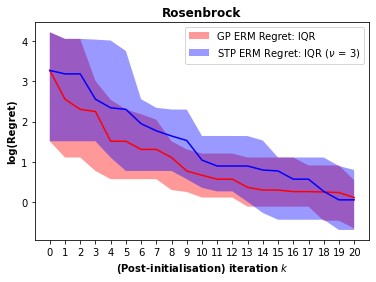

In [95]:
### Visualise!

title = obj_func

plt.figure()

plt.plot(median_gp, color = 'Red')
plt.plot(median_stp, color = 'Blue')

xstar = np.arange(0, max_iter+1, step=1)
plt.fill_between(xstar, lower_gp, upper_gp, facecolor = 'Red', alpha=0.4, label='GP ERM Regret: IQR')
plt.fill_between(xstar, lower_stp, upper_stp, facecolor = 'Blue', alpha=0.4, label='STP ERM Regret: IQR ' r'($\nu$' ' = {})'.format(df))

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialisation) iteration $\it{k}$', weight = 'bold') # x-axis label
plt.ylabel('log(Regret)', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show() #visualise!
